In [1]:
import matplotlib.pyplot as plt
import uproot
import numpy as np
import pandas as pd


from datetime import datetime
from pathlib import Path
from sklearn.model_selection import train_test_split


import sys
sys.path.insert(1, '/afs/desy.de/user/a/axelheim/private/MC_studies/Dstlnu_Bt_generic/util_funcs/')
from pandas_colFuncs import B_ID, whichBisSig, D0_decay_type, whichBisSig_NAHS

## set paths and conditions

In [ ]:
save_data = False

delete_top_numFSP_evts=True

In [3]:
nfs_path = "/nfs/dust/belle2/user/axelheim/MC_studies/ROEcleanup/caupi/"

In [4]:
data_savedir = "data/OneBGcat/"
rawData_subdir = "onlineRawData/svenjasCutsRun1/"  

## load the raw data

In [5]:
fileFSPs = uproot.open(nfs_path + rawData_subdir + "FSPs.root:variables")

In [6]:
df_FSPs = fileFSPs.arrays(library="pd")
df_FSPs.shape[0]

26835426

In [7]:
Bsig_cand_File = uproot.open(nfs_path + rawData_subdir +  "Bsig_cand.root:variables")

In [8]:
Bsig_cand_df = Bsig_cand_File.arrays(library="pd")
Bsig_cand_df.shape[0]

1494549

## overview of data properties

In [9]:
FSPs_noDuplis = df_FSPs.drop_duplicates(subset=("uniqueParticleIdentifier","__event__"), keep='first')
nonBsig_FSPs = FSPs_noDuplis[FSPs_noDuplis["Bsig_used"] == 0]
#df_FSPs.groupby(["uniqueParticleIdentifier",'__event__', '__production__']).ngroups

print("FSPs per event:", round(FSPs_noDuplis.shape[0] / FSPs_noDuplis["__event__"].nunique(), 2))
print("non Bsig FSPs per event:", round(nonBsig_FSPs.shape[0] / nonBsig_FSPs["__event__"].nunique(), 2))

FSPs per event: 17.96
non Bsig FSPs per event: 14.11


<AxesSubplot:>

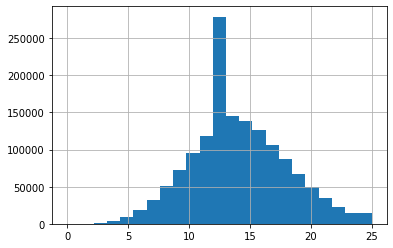

In [10]:
bins = np.linspace(0, 25, 24)

numberOfFSPs = pd.DataFrame({'numFSPs' : nonBsig_FSPs.groupby( ["__event__"] ).size()}).reset_index()
numberOfFSPs["numFSPs"].hist(bins=bins)

In [11]:
Bsig_cand_df['Bsig_isSignal'].mean()

0.06660659046573777

In [12]:
Bsig_cand_df.shape[0]

1494549

# pre selection and labeling

### delete FSP duplicates and Bsig descendants

In [13]:
FSPs_noDuplis = df_FSPs.drop_duplicates(subset=("uniqueParticleIdentifier","__event__"), keep='first')
nonBsig_FSPs = FSPs_noDuplis[FSPs_noDuplis["Bsig_used"] == 0]

### which B is Bsig? and is it the real D*lv one?

In [14]:
Bsig_cand_df['Bsig_uniqParID'] = Bsig_cand_df.apply(whichBisSig_NAHS, axis=1)

In [15]:
Bsig_cand_df['Bsig_uniqParID'].value_counts()

83886081.0    784415
83886082.0    710134
Name: Bsig_uniqParID, dtype: int64

### label and filter D0 modes

In [16]:
Bsig_cand_df['D0_decay'] = Bsig_cand_df.apply(D0_decay_type, axis=1)

In [17]:
Bsig_cand_df['D0_decay'].value_counts()

notWanted     1109498
Kpipi0         191731
Kpipipi         80740
Kpipipipi0      58748
Kpi             53832
Name: D0_decay, dtype: int64

In [18]:
Bsig_cand_df = Bsig_cand_df[Bsig_cand_df['D0_decay'] != "notWanted"]
Bsig_cand_df.shape[0]

385051

In [19]:
print(nonBsig_FSPs.shape[0])
print(nonBsig_FSPs["__event__"].nunique())


nonBsig_FSPs = nonBsig_FSPs[nonBsig_FSPs['__event__'].isin(Bsig_cand_df["__event__"])]


print(nonBsig_FSPs.shape[0])
print(nonBsig_FSPs["__event__"].nunique())

21083128
1494546
5081787
385050


## label FSPs

In [20]:
print(nonBsig_FSPs.shape[0])
nonBsig_FSPs = pd.merge(nonBsig_FSPs, Bsig_cand_df[["__event__","Bsig_uniqParID"]], on="__event__")
print(nonBsig_FSPs.shape[0])

5081787
5081787


In [ ]:
nonBsig_FSPs['B_ID'] = nonBsig_FSPs.apply(B_ID, axis=1)

In [ ]:
seperationCase="OneBGcat"


if seperationCase == "OneBGcat":
    def labels(s):
        label = -1
        if int(s['B_ID']) == 0:
            label = 0 # background, cause not related to MC Particles
        else: 
            B_sigID = s['Bsig_uniqParID']

            if int(s['B_ID']) == B_sigID:
                label = 0 # Bsig
            else:
                label = 1 # Btag
        return label
elif seperationCase == "Bsig-Btag-bg":
    def labels(s):
        label = -1
        if int(s['B_ID']) == 0:
            label = 0 # background, cause not related to MC Particles
        else: 
            B_sigID = s['Bsig_uniqParID']

            if int(s['B_ID']) == B_sigID:
                label = 2 # Bsig
            else:
                label = 1 # Btag
        return label
elif seperationCase == "B-bg":
    def labels(s):
        label = -1
        if int(s['B_ID']) == 0:
            label = 0 # background, cause not related to MC Particles
        else: 
            label = 1 # B
        return label

In [ ]:
nonBsig_FSPs['label'] = nonBsig_FSPs.apply(labels, axis=1)

In [ ]:
nonBsig_FSPs['label'].value_counts()

In [ ]:
nonBsig_FSPs['label'].value_counts(normalize=True)

## new step: only for Bsig isSig==1, check which evts still have label==2, despite Bsig isSig==1

In [30]:
label2_FSPs = nonBsig_FSPs[nonBsig_FSPs['label']==2]

In [31]:
TMP_nonLabel2_FSPs = nonBsig_FSPs[~nonBsig_FSPs['__event__'].isin(label2_FSPs["__event__"])]

In [32]:
TMP_nonLabel2_FSPs["label"].value_counts()

1    240192
0     48529
Name: label, dtype: int64

In [33]:
TMP_nonLabel2_FSPs["__event__"].nunique()

28846

In [34]:
Bsig_cand_df_tmp = Bsig_cand_df[Bsig_cand_df['__event__'].isin(TMP_nonLabel2_FSPs["__event__"])]

In [35]:
Bsig_cand_df_tmp.shape[0]

28846

In [36]:
Bsig_cand_df_tmp['D0_decay'].value_counts()

Kpipi0        14409
Kpi           11900
Kpipipi        2184
Kpipipipi0      353
Name: D0_decay, dtype: int64

In [37]:
#Bsig_cand_df = Bsig_cand_df_tmp
#nonBsig_FSPs = TMP_nonLabel2_FSPs

### check max num FSPs per event

<AxesSubplot:>

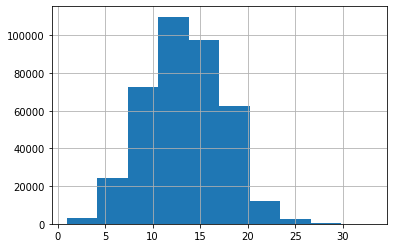

In [86]:
numberFSPsEvts = pd.DataFrame({'count' : nonBsig_FSPs.groupby(["__event__"]).size()}).reset_index()
numberFSPsEvts['count'].hist()

In [87]:
numberFSPsEvts['count'].max()

33

## delete delete_top_numFSP_evts

In [88]:
# print first to adjust percentile used
print("original max FSPs:",numberFSPsEvts["count"].max())
for percentile_lvl in [0.995,0.996,0.997,0.998,0.999]:
    print(percentile_lvl)
    percentile = numberFSPsEvts["count"].quantile(q=percentile_lvl)
    cut_numberFSPsEvts = numberFSPsEvts[numberFSPsEvts["count"] < percentile]
    
    #TMP_df_FSPs = df_FSPs[df_FSPs['__event__'].isin(cut_numberFSPsEvts["__event__"])]
    TMP_nonBsig_FSPs = nonBsig_FSPs[nonBsig_FSPs['__event__'].isin(cut_numberFSPsEvts["__event__"])]
    
    print("would delete", round(100 - (TMP_nonBsig_FSPs.shape[0]/TMP_nonBsig_FSPs.shape[0])*100,6),"% of evts")
    print("new max FSPs:",cut_numberFSPsEvts["count"].max())

original max FSPs: 33
0.995
would delete 0.0 % of evts
new max FSPs: 23
0.996
would delete 0.0 % of evts
new max FSPs: 24
0.997
would delete 0.0 % of evts
new max FSPs: 24
0.998
would delete 0.0 % of evts
new max FSPs: 25
0.999
would delete 0.0 % of evts
new max FSPs: 26


In [89]:
print(Bsig_cand_df.shape[0])
print(nonBsig_FSPs.shape[0])

385051
5081787


In [90]:
print(nonBsig_FSPs.shape[0])
print(Bsig_cand_df.shape[0])
numEvtsBeforeCut = nonBsig_FSPs.shape[0]

if delete_top_numFSP_evts:
    delete_percentileLvl = 0.995
    print("used delete_percentileLvl:",delete_percentileLvl)
    
    
    print(numberFSPsEvts["count"].describe())
    
    percentile = numberFSPsEvts["count"].quantile(q=delete_percentileLvl)
    cut_numberFSPsEvts = numberFSPsEvts[numberFSPsEvts["count"] < percentile]
    
    nonBsig_FSPs = nonBsig_FSPs[nonBsig_FSPs['__event__'].isin(cut_numberFSPsEvts["__event__"])]
    Bsig_cand_df = Bsig_cand_df[Bsig_cand_df['__event__'].isin(cut_numberFSPsEvts["__event__"])]
    
print(nonBsig_FSPs.shape[0])
print(Bsig_cand_df.shape[0])
print("deleted", round(100 - (nonBsig_FSPs.shape[0]/numEvtsBeforeCut)*100,4),"% of events")
numberFSPsEvts = pd.DataFrame({'count' : nonBsig_FSPs.groupby(["__event__"]).size()}).reset_index()
print(numberFSPsEvts["count"].describe())

5081787
385051
used delete_percentileLvl: 0.995
count    385050.000000
mean         13.197733
std           4.002662
min           1.000000
25%          10.000000
50%          13.000000
75%          16.000000
max          33.000000
Name: count, dtype: float64
5006357
382045
deleted 1.4843 % of events
count    382045.000000
mean         13.104103
std           3.874085
min           1.000000
25%          10.000000
50%          13.000000
75%          16.000000
max          23.000000
Name: count, dtype: float64


### impute the nan values of variables

In [91]:
## data preprocessing, dealing with NaN
imputelist = [["pionID",-1.],["kaonID",-1.],["electronID",-1.],["muonID",-1.],["protonID",-1.]
              ,["clusterReg",-1.],["clusterE9E21",-1.]
              ]
for impute in imputelist:
    column_name = impute[0]
    impute_val = impute[1]
    print(nonBsig_FSPs[nonBsig_FSPs[column_name].isna() == True].shape[0])    
    mask = nonBsig_FSPs[column_name].isna() == 1
    nonBsig_FSPs.loc[mask, column_name] = impute_val
    print(nonBsig_FSPs[nonBsig_FSPs[column_name].isna() == True].shape[0])

3072068
0
3072068
0
3072068
0
3072068
0
3072068
0
618957
0
618957
0


### check that each particles occurs only ones; count must be == 1 for all

In [92]:
groupsFSPs_uniqParID = pd.DataFrame({'count' : df_FSPs.groupby( ["__event__","uniqueParticleIdentifier"] ).size()}).reset_index()
groupsFSPs_uniqParID.value_counts('count')

count
1    26835426
dtype: int64

## save & load labeled and processed df's

### save

In [93]:
nonBsig_FSPs.to_csv(nfs_path + rawData_subdir +  "nonBsig_FSPs_preProcessed.csv")
Bsig_cand_df.to_csv(nfs_path + rawData_subdir + "Bsig_cand_df_preProcessed.csv")

In [103]:
Bsig_cand_df.to_csv(nfs_path + rawData_subdir + "Bsig_cand_df_preProcessed.csv")

In [104]:
print(Bsig_cand_df.shape[0])
print(nonBsig_FSPs.shape[0])

382045
5006357


In [105]:
print("save successful")

save successful


### load

In [6]:
nonBsig_FSPs = pd.read_csv(nfs_path + rawData_subdir +  "nonBsig_FSPs_preProcessed.csv")

In [ ]:
Bsig_cand_df = pd.read_csv(nfs_path + rawData_subdir +  "Bsig_cand_df_preProcessed.csv")

In [11]:
numberOfFSPs[(numberOfFSPs["numFSPs"] >= 5)  & (numberOfFSPs["numFSPs"] <= 13)].shape[0]

49239

<AxesSubplot:>

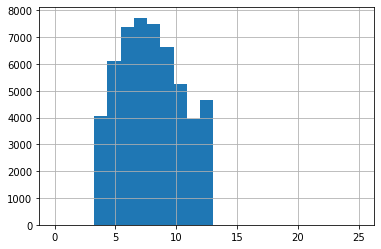

In [15]:
bins = np.linspace(0, 25, 24)

numberOfFSPs = pd.DataFrame({'numFSPs' : nonBsig_FSPs.groupby( ["__event__"] ).size()}).reset_index()
numberOfFSPs[(numberOfFSPs["numFSPs"] >= 4)  & (numberOfFSPs["numFSPs"] <= 13)]["numFSPs"].hist(bins=bins)

In [14]:
numberOfFSPs[(numberOfFSPs["numFSPs"] >= 4)  & (numberOfFSPs["numFSPs"] <= 13)].shape[0]

53314

<AxesSubplot:>

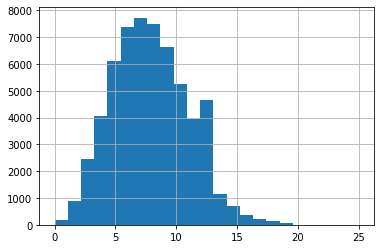

In [12]:
numberOfFSPs["numFSPs"].hist(bins=bins)

# beginning of data prod

In [106]:
df_FSPs_final = nonBsig_FSPs

## definition of input vars to be saved

In [107]:
variable_combinations = [
    [[],"caupi_only4mom"],
    [["M","charge","dr","dz","clusterReg","clusterE9E21","pionID","kaonID","electronID","muonID","protonID",
     ],"caupi_allExtras"],
    [["charge","dr","clusterE9E21"],"caupi_chrg_dr_E9E21"],
    [[    "charge","dr","dz","clusterReg","clusterE9E21","pionID","kaonID","electronID","muonID","protonID",
     ],"caupi_no_M"],
    [["M",         "dr","dz","clusterReg","clusterE9E21","pionID","kaonID","electronID","muonID","protonID",
     ],"caupi_no_charge"],
    [["M","charge",     "dz","clusterReg","clusterE9E21","pionID","kaonID","electronID","muonID","protonID",
     ],"caupi_no_dr"],
    [["M","charge","dr",     "clusterReg","clusterE9E21","pionID","kaonID","electronID","muonID","protonID",
     ],"caupi_no_dz"],
    [["M","charge","dr","dz",             "clusterE9E21","pionID","kaonID","electronID","muonID","protonID",
     ],"caupi_no_clReg"],
    [["M","charge","dr","dz","clusterReg",               "pionID","kaonID","electronID","muonID","protonID",
     ],"caupi_no_E9E21"],
    [["M","charge","dr","dz","clusterReg","clusterE9E21",         "kaonID","electronID","muonID","protonID",
     ],"caupi_no_pID"],
    [["M","charge","dr","dz","clusterReg","clusterE9E21","pionID",         "electronID","muonID","protonID",
     ],"caupi_no_kID"],
    [["M","charge","dr","dz","clusterReg","clusterE9E21","pionID","kaonID",             "muonID","protonID",
     ],"caupi_no_eID"],
    [["M","charge","dr","dz","clusterReg","clusterE9E21","pionID","kaonID","electronID"         ,"protonID",
     ],"caupi_no_muID"],
    [["M","charge","dr","dz","clusterReg","clusterE9E21","pionID","kaonID","electronID","muonID"           ,
     ],"caupi_no_proID"],
    [["charge","pionID","muonID",],"caupi_charge_mpIDs"],
    [["charge"],"caupi_charge"]
]

In [107]:
variable_combinations = [
    [["M","charge","dr","dz","clusterReg","clusterE9E21","pionID","kaonID","electronID","muonID","protonID",
     ],"caupi_allExtras"],
    [[],"caupi_only4mom"]
]

In [108]:
len(variable_combinations)

16

## start of saving

In [109]:
numFSPs = pd.DataFrame({'count' : df_FSPs_final.groupby( ["__event__"] ).size()}).reset_index()

minFSPs = numFSPs["count"].min()
maxFSPs = numFSPs["count"].max()
print("minFSPs:",minFSPs)
print("maxFSPs:",maxFSPs,'\n')
print("num Events:",numFSPs.shape[0],'\n')

df_FSPs_final['numFSPs'] = df_FSPs_final.groupby('__event__')['__event__'].transform('count')

minFSPs: 1
maxFSPs: 23 

num Events: 382045 



In [110]:
now = datetime.now()
print("time at start =", now)

time at start = 2022-02-04 12:15:37.708084


In [111]:
save_data

True

In [ ]:
minFSPs = 2 # minimum: Btag: 2 particles
for var_comb in variable_combinations:
    ablationSub = var_comb[1]
    data_dir = Path(nfs_path + data_savedir + "/" + ablationSub + "/")    
    if save_data:
        data_dir.mkdir(parents=True, exist_ok=True)
    print("Will save data to:", data_dir,'is', save_data ,'\n')


    
    for num_FSPs_toData in range(minFSPs, maxFSPs+1):
        df_num_subset = df_FSPs_final.copy()
        df_num_subset = df_num_subset[df_num_subset['numFSPs'] == num_FSPs_toData]


        numEvents = df_num_subset.__event__.nunique()
        print("numEvents:",numEvents)
        print("num_FSPs_toData:",num_FSPs_toData)  
        if numEvents == 0:
            print("skipped because empty \n")
            continue

        if numEvents < 10:
            print("skipped because <10 events \n")
            continue

        num_features = 4 + len(var_comb[0])
        leaves = np.zeros((numEvents, num_FSPs_toData,  num_features))  
        SA_target =  np.zeros((numEvents, num_FSPs_toData))
        global_tag = np.chararray((numEvents, num_FSPs_toData + 1), itemsize=30)

        event_list = df_num_subset[df_num_subset["numFSPs"] == num_FSPs_toData]["__event__"].unique()
        #print("len(event_list):",len(event_list))
        for i in range(numEvents):

            event_iter = event_list[i]

            global_tag_masterInfo = "evt" + str(event_iter)
            global_tag[i,-1] = global_tag_masterInfo
            #print("global_tag[i,-1]:",global_tag[i,-1])
            #print("i:",i,"event_iter:",event_iter)

            event_df = df_num_subset[df_num_subset.__event__ == event_iter]

            for j in range(num_FSPs_toData):
                #print("numParticle:",j)
                particle = event_df.iloc[j]

                #print(particle["mcPDG"],particle["px"],particle["py"],particle["pz"],particle["E"])
                leaves[i,j,0] = particle["px"]
                leaves[i,j,1] = particle["py"]
                leaves[i,j,2] = particle["pz"]
                leaves[i,j,3] = particle["E"]
                
                for k in range(len(var_comb[0])):
                    leav_idx = k + 4
                    leaves[i,j,leav_idx] = particle[var_comb[0][k]]
                    
                


                global_tag_Info = str((particle["mcPDG"])) 
                
                
                if seperationCase == "OneBGcat":
                    tmp_globTag = ""
                    if (int(particle['B_ID']) == int(particle['Bsig_uniqParID'])) and label == 0:
                        tmp_globTag = "_Bsig"
                    if (int(particle['B_ID']) != int(particle['Bsig_uniqParID'])) and label == 0:
                        tmp_globTag = "_bg"
                    global_tag_Info += tmp_globTag
                    
                global_tag[i,j] = global_tag_Info

        
                SA_target[i,j] = particle["label"]

            del event_df


        # shuffle the data    
        for idx in np.arange(leaves.shape[0]):   # arange is like range but gives ndarray instead of list
            perms = np.random.permutation(leaves.shape[1])

            leaves[idx,:] = leaves[idx,perms]
            SA_target[idx,:] = SA_target[idx,perms]
            global_tag[idx,0:-1] = global_tag[idx,perms]





        #print(global_tag)
        train_ratio = 0.8
        validation_ratio = 0.2
        #test_ratio = 0.1

        print("leaves.shape:",leaves.shape)
        print("SA_target.shape:",SA_target.shape)
        print("global_tag.shape:",global_tag.shape)


        print("leaves[0]:",leaves[0])
        print("SA_target[0]:",SA_target[0])
        print("global_tag[0]:",global_tag[0])

        x=leaves
        y=SA_target
        z=global_tag

        x_train, x_val, y_train, y_val, z_train, z_val = train_test_split(x, y, z, test_size=1 - train_ratio, shuffle=False)
        #x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x, y, z, test_size=1 - train_ratio, shuffle=False)
        #x_val, x_test, y_val, y_test, z_val, z_test = train_test_split(x_test, y_test, z_test, test_size=test_ratio/(test_ratio + validation_ratio), shuffle=False) 

        if save_data==True:
            np.save(data_dir / "leaves_train_FSP{}.npy".format(num_FSPs_toData), x_train)
            np.save(data_dir / "is_left_arr_train_FSP{}.npy".format(num_FSPs_toData), y_train)
            np.save(data_dir / "global_tag_train_FSP{}.npy".format(num_FSPs_toData), z_train)

            np.save(data_dir / "leaves_val_FSP{}.npy".format(num_FSPs_toData), x_val)
            np.save(data_dir / "is_left_arr_val_FSP{}.npy".format(num_FSPs_toData), y_val)
            np.save(data_dir / "global_tag_val_FSP{}.npy".format(num_FSPs_toData), z_val)

            #np.save(data_dir / "leaves_test_FSP{}.npy".format(num_FSPs_toData), x_test)
            #np.save(data_dir / "is_left_arr_test_FSP{}.npy".format(num_FSPs_toData), y_test)
            #np.save(data_dir / "global_tag_test_FSP{}.npy".format(num_FSPs_toData), z_test)


        print("")


        del df_num_subset


Will save data to: /nfs/dust/belle2/user/axelheim/MC_studies/ROEcleanup/caupi/data/svenjasCutsRun1/caupi_only4mom is True 

numEvents: 200
num_FSPs_toData: 2
leaves.shape: (200, 2, 4)
SA_target.shape: (200, 2)
global_tag.shape: (200, 3)
leaves[0]: [[ 0.15306619  0.09843379 -0.12408341  0.22026157]
 [ 0.33891129 -0.63643247  0.16347708  0.88901568]]
SA_target[0]: [2. 1.]
global_tag[0]: [b'211.0' b'321.0' b'evt4609839']

numEvents: 711
num_FSPs_toData: 3
leaves.shape: (711, 3, 4)
SA_target.shape: (711, 3)
global_tag.shape: (711, 4)
leaves[0]: [[-0.09183668 -0.27443492 -0.10916978  0.33933234]
 [-0.82548976 -1.34078836 -0.34671479  1.61571087]
 [ 1.17828846 -0.54404998  1.03501797  1.73185832]]
SA_target[0]: [1. 2. 1.]
global_tag[0]: [b'11.0' b'-13.0' b'321.0' b'evt30918408']

numEvents: 1976
num_FSPs_toData: 4
leaves.shape: (1976, 4, 4)
SA_target.shape: (1976, 4)
global_tag.shape: (1976, 5)
leaves[0]: [[-0.15210707  0.33351189  0.29252765  0.46897672]
 [ 0.47992659  0.2805433   0.8254812


numEvents: 32622
num_FSPs_toData: 15
leaves.shape: (32622, 15, 4)
SA_target.shape: (32622, 15)
global_tag.shape: (32622, 16)
leaves[0]: [[ 0.24001774 -0.02969649  0.04142801  0.55129271]
 [-0.03242939 -0.7875365   0.50190693  0.934439  ]
 [ 0.08074895  0.3695659   0.63012171  0.74250684]
 [ 0.04623144 -0.159806    0.21054229  0.26833442]
 [-0.02307003 -0.06466629  0.17769547  0.19049838]
 [-0.28595948 -0.4299435  -0.01561827  0.52728727]
 [ 0.19848947 -0.38297653  0.59096485  0.74484122]
 [ 0.05883331  0.01682105 -0.09829672  0.11578667]
 [-0.00367478 -0.06531335 -0.01315624  0.06672649]
 [ 0.70575911  0.22900486  0.31524506  0.80617529]
 [-0.03798432 -0.08396643 -0.01784381  0.09386997]
 [ 0.42770985 -0.54806632  0.1036665   0.71661638]
 [ 0.20472787 -0.17923523  0.0401145   0.27504171]
 [-0.00598414 -0.16539739  0.13628933  0.2143989 ]
 [ 0.01482826 -0.0403527   0.02247061  0.04850924]]
SA_target[0]: [2. 2. 1. 1. 1. 1. 2. 0. 1. 1. 1. 2. 2. 1. 0.]
global_tag[0]: [b'321.0' b'-211.0' b


numEvents: 3923
num_FSPs_toData: 22
leaves.shape: (3923, 22, 4)
SA_target.shape: (3923, 22)
global_tag.shape: (3923, 23)
leaves[0]: [[-0.2310719  -0.09804741  0.0917526   0.30150614]
 [-0.23912156  0.26727304 -0.0721916   0.38077462]
 [-0.10672641 -0.48063698  0.21054639  0.53547383]
 [ 0.10736103  0.18454801 -0.09328967  0.2716012 ]
 [ 0.35822394 -0.17180917  0.31199011  0.50515405]
 [ 0.07350408  0.0104068   0.12623271  0.14644402]
 [ 0.02687512  0.08615381 -0.02556141  0.09379838]
 [-0.08408925 -0.13973415  0.05171745  0.22079679]
 [-0.09560569  0.10011864 -0.15337026  0.20660742]
 [-0.06161199  0.25610253  0.24986157  0.61280692]
 [-0.04899584  0.0642244   0.19804849  0.21388915]
 [ 0.17592305  0.08452188  0.07803333  0.25231322]
 [ 0.04292141  0.10568156 -0.03439545  0.1191381 ]
 [-0.01384642  0.60058737  0.14408787  0.63335465]
 [-0.12059709  0.05685307 -0.12421016  0.22952992]
 [ 0.19755264 -0.04762593  0.10605825  0.25240308]
 [-0.38025016  0.74845755  0.17285928  0.98912901]



numEvents: 12452
num_FSPs_toData: 7
leaves.shape: (12452, 7, 15)
SA_target.shape: (12452, 7)
global_tag.shape: (12452, 8)
leaves[0]: [[ 3.40819508e-02 -2.07567856e-01  1.65327027e-01  3.01759693e-01
   1.39570385e-01  1.00000000e+00  4.50541166e-03 -3.69682600e-03
  -1.00000000e+00 -1.00000000e+00  6.85542001e-01  2.71152773e-14
   1.79084995e-07  3.14457820e-01  2.58643680e-24]
 [ 4.36593145e-02  5.36829941e-02  5.72300851e-02  8.97957808e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.93164062e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [ 6.18374228e-01 -6.10344149e-02  9.53912884e-02  6.43965276e-01
   1.39570385e-01 -1.00000000e+00  1.21468675e-03 -1.37411377e-02
   2.00000000e+00  8.01757812e-01  8.84390312e-01  2.07447152e-35
   1.13506368e-01  2.10331918e-03  2.34282361e-28]
 [ 2.13503540e-01  7.24693954e-01  1.22099154e-01  7.72552252e-01
   1.05658367e-01 -1.00000000e+00  3.33850090e-03  2.


numEvents: 34740
num_FSPs_toData: 11
leaves.shape: (34740, 11, 15)
SA_target.shape: (34740, 11)
global_tag.shape: (34740, 12)
leaves[0]: [[ 4.24945727e-02  2.65144221e-02  1.11444719e-01  1.22183177e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   1.00000000e+00  1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-6.43564528e-03  7.73886442e-02 -3.65509093e-02  8.58276689e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.09179688e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-2.37362936e-01 -3.45928311e-01  7.52360106e-01  8.67880740e-01
   1.05658367e-01  1.00000000e+00  8.94994206e-03 -8.76415697e-03
   1.00000000e+00  9.87304688e-01  1.69614307e-02  3.95078902e-09
   2.49644473e-06  9.83036069e-01  4.10024534e-18]
 [ 1.00973874e-01 -6.48560002e-03  7.30409697e-02  1.24790903e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09


numEvents: 36458
num_FSPs_toData: 14
leaves.shape: (36458, 14, 15)
SA_target.shape: (36458, 14)
global_tag.shape: (36458, 15)
leaves[0]: [[-1.62081480e-01  3.20832767e-02  3.38717669e-01  3.76867884e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   1.00000000e+00  9.17968750e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [ 2.09309936e-01 -5.27988710e-02  1.25391200e-01  2.49642390e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [ 7.14862123e-02 -7.28309005e-02  1.50350571e-01  1.81713821e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-2.09530860e-01 -7.71628246e-02  4.21803385e-01  4.88813941e-01
   1.05658367e-01 -1.00000000e+00  9.03820236e-03


numEvents: 22817
num_FSPs_toData: 17
leaves.shape: (22817, 17, 15)
SA_target.shape: (22817, 17)
global_tag.shape: (22817, 18)
leaves[0]: [[-3.88194203e-01  3.54579836e-02  9.33465138e-02  4.00831111e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.88281250e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [ 1.82003722e-01 -3.02710503e-01  9.80552137e-02  3.92241916e-01
   1.39570385e-01 -1.00000000e+00  5.30456837e-03  8.16204304e-03
   2.00000000e+00  8.59375000e-01  9.71095337e-01  2.05354001e-26
   3.78822876e-07  2.89042844e-02  1.80651522e-47]
 [-1.80632934e-01 -1.51646614e-01  2.47382522e-01  3.41793892e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-3.99580091e-01 -2.96762645e-01  1.16794385e-01  5.29955788e-01
   1.39570385e-01  1.00000000e+00  6.81369577e-03


numEvents: 12936
num_FSPs_toData: 19
leaves.shape: (12936, 19, 15)
SA_target.shape: (12936, 19)
global_tag.shape: (12936, 20)
leaves[0]: [[ 6.42349273e-002  2.60363370e-001 -1.60721019e-001  3.12644297e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000  9.72656250e-001 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000 -1.00000000e+000]
 [ 2.13083941e-002 -2.06971496e-001 -1.10476196e-001  2.73817695e-001
   1.39570385e-001  1.00000000e+000  2.95895902e-003  2.08133168e-002
  -1.00000000e+000 -1.00000000e+000  8.01998886e-001  1.53347867e-017
   6.63230207e-002  1.31678094e-001  1.74852846e-027]
 [ 1.36490002e-001 -1.81758061e-001  2.61050016e-001  3.46139602e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000  9.80468750e-001 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000 -1.00000000e+000]
 [ 2.06392810e-001 -2.95531005e-001  5.04914641e-001  6.29316337e-001



numEvents: 6099
num_FSPs_toData: 21
leaves.shape: (6099, 21, 15)
SA_target.shape: (6099, 21)
global_tag.shape: (6099, 22)
leaves[0]: [[-5.12952387e-01  4.95407999e-01  5.86066782e-01  9.33543466e-01
   1.39570385e-01  1.00000000e+00  1.38149106e-03  3.07006303e-02
   2.00000000e+00  9.74609375e-01  9.99926910e-01  4.58874708e-18
   1.64538273e-09  7.30880057e-05  1.95579817e-38]
 [-6.42656088e-02 -1.05511844e-01  6.36620373e-02  1.38980836e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-8.13469291e-02  1.81253418e-01  7.29176477e-02  2.11629648e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.99023438e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [ 9.71677601e-02 -1.91296153e-02  3.43135521e-02  1.04809044e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.


numEvents: 2314
num_FSPs_toData: 23
leaves.shape: (2314, 23, 15)
SA_target.shape: (2314, 23)
global_tag.shape: (2314, 24)
leaves[0]: [[-3.40825543e-002  7.22911805e-002  2.21909378e-002  8.29462055e-002
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000  9.56054688e-001 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000 -1.00000000e+000]
 [-5.62530607e-002  5.81351900e-003 -3.43449675e-002  6.61647990e-002
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000  1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000 -1.00000000e+000]
 [-9.66197774e-002  1.61966812e-002 -2.45118588e-002  1.00987846e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000  1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000 -1.00000000e+000]
 [ 9.77162495e-002 -5.35303392e-002  6.76475698e-003  1.11623136e-001
   0


numEvents: 4296
num_FSPs_toData: 5
leaves.shape: (4296, 5, 7)
SA_target.shape: (4296, 5)
global_tag.shape: (4296, 6)
leaves[0]: [[ 1.11744560e-01 -9.67883542e-02  2.71289855e-01  3.08954718e-01
   0.00000000e+00  1.18686603e-09  1.00000000e+00]
 [ 1.17730759e-01 -2.53894348e-02  6.46418482e-02  1.36688418e-01
   0.00000000e+00  1.18686603e-09  9.67773438e-01]
 [ 8.78294170e-01 -2.19398260e-01  4.91620690e-01  1.14234151e+00
   1.00000000e+00  2.98242775e-03  9.63867188e-01]
 [-8.25852871e-01 -8.35264400e-02  1.50572568e-01  9.77444985e-01
  -1.00000000e+00  1.83132478e-03  9.89257812e-01]
 [-2.42283210e-01  9.79152858e-01  2.90553331e-01  1.05893466e+00
   1.00000000e+00  2.27679245e-04  1.00000000e+00]]
SA_target[0]: [1. 1. 2. 2. 0.]
global_tag[0]: [b'22.0' b'22.0' b'321.0' b'-211.0' b'nan' b'evt2332754']

numEvents: 7777
num_FSPs_toData: 6
leaves.shape: (7777, 6, 7)
SA_target.shape: (7777, 6)
global_tag.shape: (7777, 7)
leaves[0]: [[ 1.53369203e-01  3.23859811e-01  1.52317107e-01  6


numEvents: 37385
num_FSPs_toData: 12
leaves.shape: (37385, 12, 7)
SA_target.shape: (37385, 12)
global_tag.shape: (37385, 13)
leaves[0]: [[ 6.67329252e-01  8.97972763e-01 -4.14915057e-03  1.12746642e+00
   1.00000000e+00  1.32781422e-02  7.99804688e-01]
 [ 2.78025359e-01 -6.32073283e-02  6.84988499e-01  7.41958563e-01
   0.00000000e+00  1.18686603e-09  9.85351562e-01]
 [ 3.78077216e-02  7.09360391e-02 -9.51899663e-02  1.24589226e-01
   0.00000000e+00  1.18686603e-09  9.01367188e-01]
 [-5.23102991e-02  4.56460863e-02  2.57747117e-02  7.40558462e-02
   0.00000000e+00  1.18686603e-09  1.00000000e+00]
 [-1.98876902e-01 -1.92721821e-02  2.98002250e-02  2.02018546e-01
   0.00000000e+00  1.18686603e-09  9.29687500e-01]
 [ 9.43337828e-02 -5.34068309e-02 -3.20655890e-02  1.13045806e-01
   0.00000000e+00  1.18686603e-09  9.72656250e-01]
 [-3.83896321e-01 -2.70004451e-01  1.21487021e-01  4.96187037e-01
   1.00000000e+00  8.49661674e-03  1.00000000e+00]
 [ 7.95640424e-02 -1.13579586e-01  2.4311490


numEvents: 22817
num_FSPs_toData: 17
leaves.shape: (22817, 17, 7)
SA_target.shape: (22817, 17)
global_tag.shape: (22817, 18)
leaves[0]: [[-3.88194203e-01  3.54579836e-02  9.33465138e-02  4.00831111e-01
   0.00000000e+00  1.18686603e-09  9.88281250e-01]
 [ 1.03091076e-01  4.76934612e-01  7.06717551e-01  9.90586221e-01
  -1.00000000e+00  8.27920167e-03  9.92187500e-01]
 [-1.80632934e-01 -1.51646614e-01  2.47382522e-01  3.41793892e-01
   0.00000000e+00  1.18686603e-09  1.00000000e+00]
 [-7.64947087e-02 -5.85288182e-02 -5.31312115e-02  1.09999948e-01
   0.00000000e+00  1.18686603e-09  9.76562500e-01]
 [ 6.26082361e-01  6.41259998e-02 -2.51322091e-02  8.00274868e-01
   1.00000000e+00  1.36075553e-03  8.05664062e-01]
 [ 1.56966634e-02  4.28428836e-02  8.81836712e-02  9.92887596e-02
   0.00000000e+00  1.18686603e-09  9.97070312e-01]
 [ 1.82003722e-01 -3.02710503e-01  9.80552137e-02  3.92241916e-01
  -1.00000000e+00  5.30456837e-03  8.59375000e-01]
 [-6.08998202e-02  7.89406151e-02  1.3994452


numEvents: 6099
num_FSPs_toData: 21
leaves.shape: (6099, 21, 7)
SA_target.shape: (6099, 21)
global_tag.shape: (6099, 22)
leaves[0]: [[ 9.71677601e-02 -1.91296153e-02  3.43135521e-02  1.04809044e-01
   0.00000000e+00  1.18686603e-09  9.70703125e-01]
 [ 1.37395248e-01 -5.34965955e-02 -1.50268627e-02  1.48206432e-01
   0.00000000e+00  1.18686603e-09  9.77539062e-01]
 [-5.19015081e-02 -4.98668663e-02 -4.40863632e-02  8.44042553e-02
   0.00000000e+00  1.18686603e-09  9.95117188e-01]
 [ 1.98690668e-01 -5.43342829e-02  7.79492334e-02  2.20241410e-01
   0.00000000e+00  1.18686603e-09  9.80468750e-01]
 [ 3.77648175e-02 -5.26799634e-02 -2.89118849e-02  7.09736364e-02
   0.00000000e+00  1.18686603e-09  9.16015625e-01]
 [-2.58819997e-01 -1.37301221e-01  5.51681221e-01  7.96183745e-01
   1.00000000e+00  1.25945748e-02  9.83398438e-01]
 [-5.12952387e-01  4.95407999e-01  5.86066782e-01  9.33543466e-01
   1.00000000e+00  1.38149106e-03  9.74609375e-01]
 [ 1.77991971e-01  9.09920111e-02  1.19890429e-0


Will save data to: /nfs/dust/belle2/user/axelheim/MC_studies/ROEcleanup/caupi/data/svenjasCutsRun1/caupi_no_M is True 

numEvents: 200
num_FSPs_toData: 2
leaves.shape: (200, 2, 14)
SA_target.shape: (200, 2)
global_tag.shape: (200, 3)
leaves[0]: [[ 3.38911295e-01 -6.36432469e-01  1.63477078e-01  8.89015680e-01
   1.00000000e+00  1.23676207e-03  2.30433129e-02  2.00000000e+00
   9.33593750e-01  1.18611200e-08  9.99999988e-01  2.17668710e-10
   2.23010854e-10  1.54268014e-15]
 [ 1.53066188e-01  9.84337926e-02 -1.24083407e-01  2.20261575e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   9.25781250e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]]
SA_target[0]: [1. 2.]
global_tag[0]: [b'321.0' b'211.0' b'evt4609839']

numEvents: 711
num_FSPs_toData: 3
leaves.shape: (711, 3, 14)
SA_target.shape: (711, 3)
global_tag.shape: (711, 4)
leaves[0]: [[ 1.17828846e+00 -5.44049978e-01  1.03501797e+00  1.73185832e+00
   1.00000000e+00  1.803


numEvents: 24252
num_FSPs_toData: 9
leaves.shape: (24252, 9, 14)
SA_target.shape: (24252, 9)
global_tag.shape: (24252, 10)
leaves[0]: [[ 3.73424441e-01 -8.58223379e-01  8.22792530e-01  1.24618658e+00
  -1.00000000e+00  1.99435666e-03  2.02720260e-02  2.00000000e+00
   9.73632812e-01  7.43675419e-06  2.52204620e-14  9.99990704e-01
   1.85922223e-06  7.59972752e-23]
 [ 7.71116689e-02  1.63555276e-02  8.82026623e-04  7.88320413e-02
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-4.30509150e-02  2.47533582e-02 -3.59910391e-02  6.13307828e-02
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   9.78515625e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 2.49388572e-02  1.81682199e-01 -7.03078806e-02  1.96401543e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   9.56054688e-01 -1.00000000e+00 


numEvents: 37716
num_FSPs_toData: 13
leaves.shape: (37716, 13, 14)
SA_target.shape: (37716, 13)
global_tag.shape: (37716, 14)
leaves[0]: [[ 1.02572799e-01  2.50033140e-02  5.50239161e-02  1.19054509e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   9.97070312e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-4.52881455e-02 -3.13378453e-01  2.58803397e-01  4.32106656e-01
  -1.00000000e+00  2.71802786e-03  1.76045755e-03 -1.00000000e+00
  -1.00000000e+00  9.99436819e-01  1.37811911e-72  4.18479082e-04
   1.44701966e-04  1.15560031e-68]
 [-1.03092268e-01 -2.75085866e-01  2.05313101e-01  3.84621387e-01
   1.00000000e+00  1.16190226e-02  4.00828047e-03  2.00000000e+00
   1.00000000e+00  8.48948714e-01  1.90451891e-10  5.23195605e-09
   1.51051280e-01  1.51358483e-34]
 [-8.90817940e-02 -2.52849847e-01  8.52152333e-02  2.81301454e-01
  -1.00000000e+00  8.56520815e-03  9.60752279e-03 -1.00000000e+00
  -1.00000000e+00  7.06868697e-


numEvents: 28255
num_FSPs_toData: 16
leaves.shape: (28255, 16, 14)
SA_target.shape: (28255, 16)
global_tag.shape: (28255, 17)
leaves[0]: [[ 9.83645916e-002  9.31036845e-002  1.26738757e-001  1.85490165e-001
   0.00000000e+000  1.18686603e-009  2.23517418e-010  2.00000000e+000
   1.00000000e+000 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 5.79208061e-002  1.12797812e-001  1.79437280e-001  2.19717781e-001
   0.00000000e+000  1.18686603e-009  2.23517418e-010  2.00000000e+000
   9.27734375e-001 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 1.51225641e-001  1.53876722e-001  5.86379826e-001  6.24810804e-001
   0.00000000e+000  1.18686603e-009  2.23517418e-010  1.00000000e+000
   1.00000000e+000 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-2.59587407e-001  6.65742308e-002  5.96044123e-001  6.53518437e-001
   0.00000000e+000  1.18686603e-009  2.23517418e-01


numEvents: 17679
num_FSPs_toData: 18
leaves.shape: (17679, 18, 14)
SA_target.shape: (17679, 18)
global_tag.shape: (17679, 19)
leaves[0]: [[ 5.17117202e-001  1.00313127e+000  8.87770712e-001  1.71527661e+000
   1.00000000e+000  1.81065520e-004 -8.90558872e-003  2.00000000e+000
   9.19921875e-001  1.27082833e-001  1.13358844e-001  2.42392853e-010
   2.51869850e-003  7.57039564e-001]
 [ 9.94861573e-002 -1.06197067e-001 -1.57916114e-001  5.38358414e-001
   1.00000000e+000  2.38952254e-002  1.05097907e-001 -1.00000000e+000
  -1.00000000e+000  2.82570684e-122  9.99996535e-001  2.32186278e-138
   6.48870322e-179  3.46226010e-006]
 [-9.16054752e-003 -1.21924572e-001  7.25160092e-002  1.42155156e-001
   0.00000000e+000  1.18686603e-009  2.23517418e-010  2.00000000e+000
   9.90234375e-001 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-3.80761564e-001 -1.09954625e-001  3.46938699e-001  5.26721795e-001
   0.00000000e+000  1.18686603e-009  2.23517418e-01


numEvents: 9219
num_FSPs_toData: 20
leaves.shape: (9219, 20, 14)
SA_target.shape: (9219, 20)
global_tag.shape: (9219, 21)
leaves[0]: [[ 7.63550308e-003  7.78449103e-002  1.16589963e-002  7.90826350e-002
   0.00000000e+000  1.18686603e-009  2.23517418e-010  2.00000000e+000
   1.00000000e+000 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-2.98131146e-002 -5.68594038e-002  7.05377460e-002  9.53802244e-002
   0.00000000e+000  1.18686603e-009  2.23517418e-010  2.00000000e+000
   9.49218750e-001 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 1.29298717e-001 -3.04309726e-001  1.92322403e-001  3.96830146e-001
  -1.00000000e+000  4.12853609e-003  1.10389222e-002  2.00000000e+000
   9.91210938e-001  5.30979297e-002  6.14052567e-035  1.40658908e-011
   9.46902070e-001  1.97541946e-052]
 [ 2.25921720e-001  1.54042155e-001  2.61303950e-002  5.64950774e-001
  -1.00000000e+000  2.53345077e-003  1.12263270e-002 -1


numEvents: 3923
num_FSPs_toData: 22
leaves.shape: (3923, 22, 14)
SA_target.shape: (3923, 22)
global_tag.shape: (3923, 23)
leaves[0]: [[ 1.97552636e-01 -4.76259291e-02  1.06058255e-01  2.52403085e-01
  -1.00000000e+00  9.99334541e-03 -3.23647988e-03 -1.00000000e+00
  -1.00000000e+00  1.02169766e-01  4.33903784e-31  2.87323546e-04
   8.97542911e-01  3.34788139e-42]
 [-2.31071904e-01 -9.80474129e-02  9.17526037e-02  3.01506141e-01
  -1.00000000e+00  4.14024101e-03 -3.79740973e-03 -1.00000000e+00
  -1.00000000e+00  5.51357198e-01  2.38363374e-20  3.39103018e-03
   4.45251771e-01  3.18931697e-33]
 [ 3.58223945e-01 -1.71809167e-01  3.11990112e-01  5.05154050e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   9.63867188e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 1.75923049e-01  8.45218822e-02  7.80333281e-02  2.52313219e-01
   1.00000000e+00  8.35428220e-03  1.61450249e-02 -1.00000000e+00
  -1.00000000e+00  6.48905544e-01  


Will save data to: /nfs/dust/belle2/user/axelheim/MC_studies/ROEcleanup/caupi/data/svenjasCutsRun1/caupi_no_charge is True 

numEvents: 200
num_FSPs_toData: 2
leaves.shape: (200, 2, 14)
SA_target.shape: (200, 2)
global_tag.shape: (200, 3)
leaves[0]: [[ 3.38911295e-01 -6.36432469e-01  1.63477078e-01  8.89015680e-01
   4.93676990e-01  1.23676207e-03  2.30433129e-02  2.00000000e+00
   9.33593750e-01  1.18611200e-08  9.99999988e-01  2.17668710e-10
   2.23010854e-10  1.54268014e-15]
 [ 1.53066188e-01  9.84337926e-02 -1.24083407e-01  2.20261575e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   9.25781250e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]]
SA_target[0]: [1. 2.]
global_tag[0]: [b'321.0' b'211.0' b'evt4609839']

numEvents: 711
num_FSPs_toData: 3
leaves.shape: (711, 3, 14)
SA_target.shape: (711, 3)
global_tag.shape: (711, 4)
leaves[0]: [[ 1.17828846e+00 -5.44049978e-01  1.03501797e+00  1.73185832e+00
   4.93676990e-01  


numEvents: 24252
num_FSPs_toData: 9
leaves.shape: (24252, 9, 14)
SA_target.shape: (24252, 9)
global_tag.shape: (24252, 10)
leaves[0]: [[-4.30509150e-02  2.47533582e-02 -3.59910391e-02  6.13307828e-02
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   9.78515625e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 3.73424441e-01 -8.58223379e-01  8.22792530e-01  1.24618658e+00
   5.10998943e-04  1.99435666e-03  2.02720260e-02  2.00000000e+00
   9.73632812e-01  7.43675419e-06  2.52204620e-14  9.99990704e-01
   1.85922223e-06  7.59972752e-23]
 [ 2.49388572e-02  1.81682199e-01 -7.03078806e-02  1.96401543e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   9.56054688e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 9.76267755e-02  1.25952503e-02  1.27284871e-02  9.92554382e-02
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   1.00000000e+00 -1.00000000e+00 


numEvents: 37716
num_FSPs_toData: 13
leaves.shape: (37716, 13, 14)
SA_target.shape: (37716, 13)
global_tag.shape: (37716, 14)
leaves[0]: [[-4.52881455e-02 -3.13378453e-01  2.58803397e-01  4.32106656e-01
   1.39570385e-01  2.71802786e-03  1.76045755e-03 -1.00000000e+00
  -1.00000000e+00  9.99436819e-01  1.37811911e-72  4.18479082e-04
   1.44701966e-04  1.15560031e-68]
 [-2.32006069e-02  2.79273298e-02  6.77683726e-02  7.68814427e-02
   0.00000000e+00  1.18686603e-09  2.23517418e-10  1.00000000e+00
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-2.56085694e-01  5.00136793e-01  1.15037370e+00  1.28784946e+00
   1.39570385e-01  1.76776215e-02  4.76131955e-02  1.00000000e+00
   9.95117188e-01  9.62938701e-01  5.61069849e-13  1.10409552e-06
   3.70601944e-02  4.46096504e-15]
 [ 8.26296508e-02 -3.21455523e-02  4.10442315e-02  9.77017127e-02
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   1.00000000e+00 -1.00000000e+


numEvents: 28255
num_FSPs_toData: 16
leaves.shape: (28255, 16, 14)
SA_target.shape: (28255, 16)
global_tag.shape: (28255, 17)
leaves[0]: [[ 9.83645916e-002  9.31036845e-002  1.26738757e-001  1.85490165e-001
   0.00000000e+000  1.18686603e-009  2.23517418e-010  2.00000000e+000
   1.00000000e+000 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-2.76412606e-001 -1.68261096e-001  5.71810067e-001  8.21826897e-001
   4.93676990e-001  1.29421409e-003  1.65957509e-002 -1.00000000e+000
  -1.00000000e+000  8.85156284e-003  9.90159301e-001  1.18950497e-006
   9.87946850e-004  7.20704328e-013]
 [ 3.73208076e-001 -1.72477245e-001  4.08514410e-001  5.79583430e-001
   5.10998943e-004  3.83689233e-003 -2.59708065e-002 -1.00000000e+000
  -1.00000000e+000  2.51096718e-002  4.53217495e-100  9.74876424e-001
   1.39047302e-005  6.01888179e-084]
 [ 1.51225641e-001  1.53876722e-001  5.86379826e-001  6.24810804e-001
   0.00000000e+000  1.18686603e-009  2.23517418e-01


numEvents: 17679
num_FSPs_toData: 18
leaves.shape: (17679, 18, 14)
SA_target.shape: (17679, 18)
global_tag.shape: (17679, 19)
leaves[0]: [[ 5.72560504e-002 -3.15371081e-002  1.06534055e-002  6.62294462e-002
   0.00000000e+000  1.18686603e-009  2.23517418e-010  2.00000000e+000
   8.64257812e-001 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-8.22227225e-002 -9.74204913e-002  4.01733629e-002  1.93248854e-001
   1.39570385e-001  1.43104967e-002  1.24546389e-002 -1.00000000e+000
  -1.00000000e+000  9.99515412e-001  3.20740711e-011  5.02379856e-006
   4.79564000e-004  5.23890976e-014]
 [ 4.66311336e-001  7.24833131e-001  2.54507661e-001  8.98667613e-001
   0.00000000e+000  1.18686603e-009  2.23517418e-010  2.00000000e+000
   9.70703125e-001 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-2.77438946e-002 -2.46905200e-002  7.05896989e-002  7.97637201e-002
   0.00000000e+000  1.18686603e-009  2.23517418e-01


numEvents: 9219
num_FSPs_toData: 20
leaves.shape: (9219, 20, 14)
SA_target.shape: (9219, 20)
global_tag.shape: (9219, 21)
leaves[0]: [[ 4.38437760e-002 -6.52858168e-002  5.63045107e-002  9.67197627e-002
   0.00000000e+000  1.18686603e-009  2.23517418e-010  2.00000000e+000
   1.00000000e+000 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 2.25921720e-001  1.54042155e-001  2.61303950e-002  5.64950774e-001
   4.93676990e-001  2.53345077e-003  1.12263270e-002 -1.00000000e+000
  -1.00000000e+000  9.09421070e-261  1.00000000e+000  1.56333059e-173
   6.98481160e-312  3.62193418e-018]
 [ 7.63550308e-003  7.78449103e-002  1.16589963e-002  7.90826350e-002
   0.00000000e+000  1.18686603e-009  2.23517418e-010  2.00000000e+000
   1.00000000e+000 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-1.69230163e-001  1.83964550e-001 -1.10288942e-002  2.50206795e-001
   0.00000000e+000  1.18686603e-009  2.23517418e-010  2


numEvents: 3923
num_FSPs_toData: 22
leaves.shape: (3923, 22, 14)
SA_target.shape: (3923, 22)
global_tag.shape: (3923, 23)
leaves[0]: [[ 7.35040829e-02  1.04067987e-02  1.26232713e-01  1.46444015e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  1.00000000e+00
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-4.89958413e-02  6.42243996e-02  1.98048487e-01  2.13889152e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  1.00000000e+00
   9.91210938e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 2.68751159e-02  8.61538127e-02 -2.55614053e-02  9.37983835e-02
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   9.87304688e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-2.39121556e-01  2.67273039e-01 -7.21916035e-02  3.80774624e-01
   1.05658367e-01  5.86401562e-03  1.16784173e-02  2.00000000e+00
   9.72656250e-01  1.42041664e-02  


Will save data to: /nfs/dust/belle2/user/axelheim/MC_studies/ROEcleanup/caupi/data/svenjasCutsRun1/caupi_no_dr is True 

numEvents: 200
num_FSPs_toData: 2
leaves.shape: (200, 2, 14)
SA_target.shape: (200, 2)
global_tag.shape: (200, 3)
leaves[0]: [[ 3.38911295e-01 -6.36432469e-01  1.63477078e-01  8.89015680e-01
   4.93676990e-01  1.00000000e+00  2.30433129e-02  2.00000000e+00
   9.33593750e-01  1.18611200e-08  9.99999988e-01  2.17668710e-10
   2.23010854e-10  1.54268014e-15]
 [ 1.53066188e-01  9.84337926e-02 -1.24083407e-01  2.20261575e-01
   0.00000000e+00  0.00000000e+00  2.23517418e-10  2.00000000e+00
   9.25781250e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]]
SA_target[0]: [1. 2.]
global_tag[0]: [b'321.0' b'211.0' b'evt4609839']

numEvents: 711
num_FSPs_toData: 3
leaves.shape: (711, 3, 14)
SA_target.shape: (711, 3)
global_tag.shape: (711, 4)
leaves[0]: [[-9.18366760e-02 -2.74434924e-01 -1.09169781e-01  3.39332339e-01
   1.39570385e-01 -1.00


numEvents: 24252
num_FSPs_toData: 9
leaves.shape: (24252, 9, 14)
SA_target.shape: (24252, 9)
global_tag.shape: (24252, 10)
leaves[0]: [[ 2.07734883e-01  1.19945750e-01 -1.43366337e-01  3.12369274e-01
   1.39570385e-01  1.00000000e+00  1.23629255e-02  3.00000000e+00
   7.83203125e-01  7.96560789e-01  1.55498102e-18  5.34674682e-02
   1.49971743e-01  2.69227435e-34]
 [ 1.00565195e+00  8.26038420e-01 -4.89434332e-01  1.47544510e+00
   4.93676990e-01 -1.00000000e+00  1.06600613e-02  2.00000000e+00
   9.51171875e-01  8.19647196e-20  1.00000000e+00  2.31935649e-22
   1.13710997e-31  5.19655418e-51]
 [ 7.71116689e-02  1.63555276e-02  8.82026623e-04  7.88320413e-02
   0.00000000e+00  0.00000000e+00  2.23517418e-10  2.00000000e+00
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 3.73424441e-01 -8.58223379e-01  8.22792530e-01  1.24618658e+00
   5.10998943e-04 -1.00000000e+00  2.02720260e-02  2.00000000e+00
   9.73632812e-01  7.43675419e-06 


numEvents: 37716
num_FSPs_toData: 13
leaves.shape: (37716, 13, 14)
SA_target.shape: (37716, 13)
global_tag.shape: (37716, 14)
leaves[0]: [[-2.32006069e-02  2.79273298e-02  6.77683726e-02  7.68814427e-02
   0.00000000e+00  0.00000000e+00  2.23517418e-10  1.00000000e+00
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 1.02572799e-01  2.50033140e-02  5.50239161e-02  1.19054509e-01
   0.00000000e+00  0.00000000e+00  2.23517418e-10  2.00000000e+00
   9.97070312e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 8.26296508e-02 -3.21455523e-02  4.10442315e-02  9.77017127e-02
   0.00000000e+00  0.00000000e+00  2.23517418e-10  2.00000000e+00
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-8.90817940e-02 -2.52849847e-01  8.52152333e-02  2.81301454e-01
   5.10998943e-04 -1.00000000e+00  9.60752279e-03 -1.00000000e+00
  -1.00000000e+00  7.06868697e-


numEvents: 28255
num_FSPs_toData: 16
leaves.shape: (28255, 16, 14)
SA_target.shape: (28255, 16)
global_tag.shape: (28255, 17)
leaves[0]: [[ 3.26679647e-001  1.55827612e-001  3.03054973e-002  3.78264392e-001
   1.05658367e-001  1.00000000e+000 -2.30930276e-002  2.00000000e+000
   7.83203125e-001  4.45480066e-001  1.44028500e-015  9.43785674e-005
   5.54425555e-001  7.72670784e-034]
 [ 3.73208076e-001 -1.72477245e-001  4.08514410e-001  5.79583430e-001
   5.10998943e-004 -1.00000000e+000 -2.59708065e-002 -1.00000000e+000
  -1.00000000e+000  2.51096718e-002  4.53217495e-100  9.74876424e-001
   1.39047302e-005  6.01888179e-084]
 [ 6.02875315e-002  7.99693093e-002  1.41468316e-001  1.73329055e-001
   0.00000000e+000  0.00000000e+000  2.23517418e-010  2.00000000e+000
   1.00000000e+000 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-2.76412606e-001 -1.68261096e-001  5.71810067e-001  8.21826897e-001
   4.93676990e-001  1.00000000e+000  1.65957509e-00


numEvents: 17679
num_FSPs_toData: 18
leaves.shape: (17679, 18, 14)
SA_target.shape: (17679, 18)
global_tag.shape: (17679, 19)
leaves[0]: [[-2.22661689e-001 -1.10515475e-001  7.77242333e-002  2.95487473e-001
   1.39570385e-001  1.00000000e+000 -1.17539193e-003 -1.00000000e+000
  -1.00000000e+000  6.79079551e-001  1.89073528e-014  4.39009974e-002
   2.77019452e-001  8.99939305e-023]
 [ 9.94861573e-002 -1.06197067e-001 -1.57916114e-001  5.38358414e-001
   4.93676990e-001  1.00000000e+000  1.05097907e-001 -1.00000000e+000
  -1.00000000e+000  2.82570684e-122  9.99996535e-001  2.32186278e-138
   6.48870322e-179  3.46226010e-006]
 [ 5.72560504e-002 -3.15371081e-002  1.06534055e-002  6.62294462e-002
   0.00000000e+000  0.00000000e+000  2.23517418e-010  2.00000000e+000
   8.64257812e-001 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-3.80761564e-001 -1.09954625e-001  3.46938699e-001  5.26721795e-001
   0.00000000e+000  0.00000000e+000  2.23517418e-01


numEvents: 9219
num_FSPs_toData: 20
leaves.shape: (9219, 20, 14)
SA_target.shape: (9219, 20)
global_tag.shape: (9219, 21)
leaves[0]: [[ 4.38437760e-002 -6.52858168e-002  5.63045107e-002  9.67197627e-002
   0.00000000e+000  0.00000000e+000  2.23517418e-010  2.00000000e+000
   1.00000000e+000 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 5.27662516e-001 -2.61021078e-001 -2.38506526e-001  6.35173280e-001
   0.00000000e+000  0.00000000e+000  2.23517418e-010  2.00000000e+000
   9.66796875e-001 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-1.69230163e-001  1.83964550e-001 -1.10288942e-002  2.50206795e-001
   0.00000000e+000  0.00000000e+000  2.23517418e-010  2.00000000e+000
   9.58007812e-001 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-8.77844691e-002  1.36142999e-001  7.04855695e-002  1.76661384e-001
   0.00000000e+000  0.00000000e+000  2.23517418e-010  2


numEvents: 3923
num_FSPs_toData: 22
leaves.shape: (3923, 22, 14)
SA_target.shape: (3923, 22)
global_tag.shape: (3923, 23)
leaves[0]: [[-1.06726408e-01 -4.80636984e-01  2.10546389e-01  5.35473826e-01
   0.00000000e+00  0.00000000e+00  2.23517418e-10  2.00000000e+00
   9.73632812e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 3.58223945e-01 -1.71809167e-01  3.11990112e-01  5.05154050e-01
   0.00000000e+00  0.00000000e+00  2.23517418e-10  2.00000000e+00
   9.63867188e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 4.29214127e-02  1.05681561e-01 -3.43954526e-02  1.19138101e-01
   0.00000000e+00  0.00000000e+00  2.23517418e-10  2.00000000e+00
   9.73632812e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 2.89733820e-02 -3.02876174e-01  5.42327128e-02  3.26616460e-01
   1.05658367e-01  1.00000000e+00 -1.98827048e-01  2.00000000e+00
   9.77539062e-01  1.33031980e-01  


Will save data to: /nfs/dust/belle2/user/axelheim/MC_studies/ROEcleanup/caupi/data/svenjasCutsRun1/caupi_no_dz is True 

numEvents: 200
num_FSPs_toData: 2
leaves.shape: (200, 2, 14)
SA_target.shape: (200, 2)
global_tag.shape: (200, 3)
leaves[0]: [[ 1.53066188e-01  9.84337926e-02 -1.24083407e-01  2.20261575e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.00000000e+00
   9.25781250e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 3.38911295e-01 -6.36432469e-01  1.63477078e-01  8.89015680e-01
   4.93676990e-01  1.00000000e+00  1.23676207e-03  2.00000000e+00
   9.33593750e-01  1.18611200e-08  9.99999988e-01  2.17668710e-10
   2.23010854e-10  1.54268014e-15]]
SA_target[0]: [2. 1.]
global_tag[0]: [b'211.0' b'321.0' b'evt4609839']

numEvents: 711
num_FSPs_toData: 3
leaves.shape: (711, 3, 14)
SA_target.shape: (711, 3)
global_tag.shape: (711, 4)
leaves[0]: [[-9.18366760e-02 -2.74434924e-01 -1.09169781e-01  3.39332339e-01
   1.39570385e-01 -1.00


numEvents: 24252
num_FSPs_toData: 9
leaves.shape: (24252, 9, 14)
SA_target.shape: (24252, 9)
global_tag.shape: (24252, 10)
leaves[0]: [[-4.30509150e-02  2.47533582e-02 -3.59910391e-02  6.13307828e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.00000000e+00
   9.78515625e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 2.49388572e-02  1.81682199e-01 -7.03078806e-02  1.96401543e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.00000000e+00
   9.56054688e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-3.23076278e-01 -2.92865932e-01  1.02640130e-01  4.69215967e-01
   1.39570385e-01  1.00000000e+00  1.77527175e-03  2.00000000e+00
   8.59375000e-01  9.99729908e-01  1.41130552e-27  1.27529950e-13
   2.70092364e-04  8.86403609e-48]
 [ 9.76267755e-02  1.25952503e-02  1.27284871e-02  9.92554382e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.00000000e+00
   1.00000000e+00 -1.00000000e+00 


numEvents: 37716
num_FSPs_toData: 13
leaves.shape: (37716, 13, 14)
SA_target.shape: (37716, 13)
global_tag.shape: (37716, 14)
leaves[0]: [[-5.68661802e-02  6.06427388e-03  7.07113668e-02  9.09430331e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.00000000e+00
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 5.19561112e-01  4.35166240e-01 -2.91180462e-02  8.38974515e-01
   4.93676990e-01  1.00000000e+00  3.15108785e-03  2.00000000e+00
   8.75976562e-01  1.81981675e-15  1.00000000e+00  8.86395766e-19
   3.72219767e-18  2.75993439e-12]
 [-8.90817940e-02 -2.52849847e-01  8.52152333e-02  2.81301454e-01
   5.10998943e-04 -1.00000000e+00  8.56520815e-03 -1.00000000e+00
  -1.00000000e+00  7.06868697e-02  3.73708052e-15  9.27988482e-01
   1.32464840e-03  1.68582008e-33]
 [ 1.49445282e-02  1.13882482e-01  1.85965866e-01  2.59337144e-01
   1.39570385e-01  1.00000000e+00  5.49949980e-02 -1.00000000e+00
  -1.00000000e+00  7.53705909e-


numEvents: 28255
num_FSPs_toData: 16
leaves.shape: (28255, 16, 14)
SA_target.shape: (28255, 16)
global_tag.shape: (28255, 17)
leaves[0]: [[-2.59587407e-001  6.65742308e-002  5.96044123e-001  6.53518437e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  1.00000000e+000
   8.08593750e-001 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 3.73208076e-001 -1.72477245e-001  4.08514410e-001  5.79583430e-001
   5.10998943e-004 -1.00000000e+000  3.83689233e-003 -1.00000000e+000
  -1.00000000e+000  2.51096718e-002  4.53217495e-100  9.74876424e-001
   1.39047302e-005  6.01888179e-084]
 [ 6.02875315e-002  7.99693093e-002  1.41468316e-001  1.73329055e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.00000000e+000
   1.00000000e+000 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-5.77757917e-002 -4.44710180e-002  9.31544378e-002  1.18293968e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-00


numEvents: 17679
num_FSPs_toData: 18
leaves.shape: (17679, 18, 14)
SA_target.shape: (17679, 18)
global_tag.shape: (17679, 19)
leaves[0]: [[-3.80761564e-001 -1.09954625e-001  3.46938699e-001  5.26721795e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.00000000e+000
   9.87304688e-001 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-9.16054752e-003 -1.21924572e-001  7.25160092e-002  1.42155156e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.00000000e+000
   9.90234375e-001 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-1.53967235e-002 -2.89486498e-001  1.53520366e-003  2.89899721e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.00000000e+000
   9.41406250e-001 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-1.61800198e-002 -1.02237567e-001  6.33947402e-002  1.21380420e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-00


numEvents: 9219
num_FSPs_toData: 20
leaves.shape: (9219, 20, 14)
SA_target.shape: (9219, 20)
global_tag.shape: (9219, 21)
leaves[0]: [[-3.40863131e-002  5.32440916e-002 -2.64656218e-003  6.32757009e-002
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.00000000e+000
   9.95117188e-001 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 8.44008401e-002  3.50738689e-002  2.12066263e-001  2.30923749e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  1.00000000e+000
   9.65820312e-001 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 8.78734291e-002 -8.27259049e-002 -3.81672569e-002  1.26578254e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.00000000e+000
   1.00000000e+000 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 5.27662516e-001 -2.61021078e-001 -2.38506526e-001  6.35173280e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2


numEvents: 3923
num_FSPs_toData: 22
leaves.shape: (3923, 22, 14)
SA_target.shape: (3923, 22)
global_tag.shape: (3923, 23)
leaves[0]: [[-4.89958413e-02  6.42243996e-02  1.98048487e-01  2.13889152e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  1.00000000e+00
   9.91210938e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 3.58223945e-01 -1.71809167e-01  3.11990112e-01  5.05154050e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.00000000e+00
   9.63867188e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 7.35040829e-02  1.04067987e-02  1.26232713e-01  1.46444015e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  1.00000000e+00
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 2.89733820e-02 -3.02876174e-01  5.42327128e-02  3.26616460e-01
   1.05658367e-01  1.00000000e+00  2.38428606e-01  2.00000000e+00
   9.77539062e-01  1.33031980e-01  


Will save data to: /nfs/dust/belle2/user/axelheim/MC_studies/ROEcleanup/caupi/data/svenjasCutsRun1/caupi_no_clReg is True 

numEvents: 200
num_FSPs_toData: 2
leaves.shape: (200, 2, 14)
SA_target.shape: (200, 2)
global_tag.shape: (200, 3)
leaves[0]: [[ 3.38911295e-01 -6.36432469e-01  1.63477078e-01  8.89015680e-01
   4.93676990e-01  1.00000000e+00  1.23676207e-03  2.30433129e-02
   9.33593750e-01  1.18611200e-08  9.99999988e-01  2.17668710e-10
   2.23010854e-10  1.54268014e-15]
 [ 1.53066188e-01  9.84337926e-02 -1.24083407e-01  2.20261575e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   9.25781250e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]]
SA_target[0]: [1. 2.]
global_tag[0]: [b'321.0' b'211.0' b'evt4609839']

numEvents: 711
num_FSPs_toData: 3
leaves.shape: (711, 3, 14)
SA_target.shape: (711, 3)
global_tag.shape: (711, 4)
leaves[0]: [[ 1.17828846e+00 -5.44049978e-01  1.03501797e+00  1.73185832e+00
   4.93676990e-01  1


numEvents: 24252
num_FSPs_toData: 9
leaves.shape: (24252, 9, 14)
SA_target.shape: (24252, 9)
global_tag.shape: (24252, 10)
leaves[0]: [[ 3.19151521e-01  3.81917685e-01 -2.19187275e-01  5.43839933e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   9.53125000e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 7.71116689e-02  1.63555276e-02  8.82026623e-04  7.88320413e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-4.30509150e-02  2.47533582e-02 -3.59910391e-02  6.13307828e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   9.78515625e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 3.73424441e-01 -8.58223379e-01  8.22792530e-01  1.24618658e+00
   5.10998943e-04 -1.00000000e+00  1.99435666e-03  2.02720260e-02
   9.73632812e-01  7.43675419e-06 


numEvents: 37716
num_FSPs_toData: 13
leaves.shape: (37716, 13, 14)
SA_target.shape: (37716, 13)
global_tag.shape: (37716, 14)
leaves[0]: [[ 5.05157262e-02  1.90063510e-02  2.83047818e-02  6.09445703e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   9.67773438e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-5.38287684e-02 -7.26629570e-02  2.55111326e-02  9.39588182e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 5.19561112e-01  4.35166240e-01 -2.91180462e-02  8.38974515e-01
   4.93676990e-01  1.00000000e+00  3.15108785e-03  5.67231775e-03
   8.75976562e-01  1.81981675e-15  1.00000000e+00  8.86395766e-19
   3.72219767e-18  2.75993439e-12]
 [-2.56085694e-01  5.00136793e-01  1.15037370e+00  1.28784946e+00
   1.39570385e-01 -1.00000000e+00  1.76776215e-02  4.76131955e-02
   9.95117188e-01  9.62938701e-


numEvents: 28255
num_FSPs_toData: 16
leaves.shape: (28255, 16, 14)
SA_target.shape: (28255, 16)
global_tag.shape: (28255, 17)
leaves[0]: [[-5.77757917e-002 -4.44710180e-002  9.31544378e-002  1.18293968e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   9.93164062e-001 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 3.73208076e-001 -1.72477245e-001  4.08514410e-001  5.79583430e-001
   5.10998943e-004 -1.00000000e+000  3.83689233e-003 -2.59708065e-002
  -1.00000000e+000  2.51096718e-002  4.53217495e-100  9.74876424e-001
   1.39047302e-005  6.01888179e-084]
 [ 6.67390451e-002 -1.49362072e-001  7.16379210e-002  2.26660568e-001
   1.39570385e-001  1.00000000e+000  6.94823281e-003 -1.75572547e-002
  -1.00000000e+000  5.93246600e-001  3.17595370e-019  3.43736867e-002
   3.72379713e-001  3.14773405e-024]
 [-7.50253975e-001 -4.53708619e-001  3.89656782e-001  1.07901896e+000
   4.93676990e-001 -1.00000000e+000  7.10918560e-00


numEvents: 17679
num_FSPs_toData: 18
leaves.shape: (17679, 18, 14)
SA_target.shape: (17679, 18)
global_tag.shape: (17679, 19)
leaves[0]: [[ 9.94861573e-002 -1.06197067e-001 -1.57916114e-001  5.38358414e-001
   4.93676990e-001  1.00000000e+000  2.38952254e-002  1.05097907e-001
  -1.00000000e+000  2.82570684e-122  9.99996535e-001  2.32186278e-138
   6.48870322e-179  3.46226010e-006]
 [-9.16054752e-003 -1.21924572e-001  7.25160092e-002  1.42155156e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   9.90234375e-001 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-2.77438946e-002 -2.46905200e-002  7.05896989e-002  7.97637201e-002
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   9.38476562e-001 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 4.66311336e-001  7.24833131e-001  2.54507661e-001  8.98667613e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-00


numEvents: 9219
num_FSPs_toData: 20
leaves.shape: (9219, 20, 14)
SA_target.shape: (9219, 20)
global_tag.shape: (9219, 21)
leaves[0]: [[ 8.78734291e-002 -8.27259049e-002 -3.81672569e-002  1.26578254e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   1.00000000e+000 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-8.77844691e-002  1.36142999e-001  7.04855695e-002  1.76661384e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   9.80468750e-001 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 9.53983739e-002 -2.09491730e-001 -2.02448815e-001  3.06550416e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   9.51171875e-001 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 1.29298717e-001 -3.04309726e-001  1.92322403e-001  3.96830146e-001
   1.05658367e-001 -1.00000000e+000  4.12853609e-003  1


numEvents: 3923
num_FSPs_toData: 22
leaves.shape: (3923, 22, 14)
SA_target.shape: (3923, 22)
global_tag.shape: (3923, 23)
leaves[0]: [[ 3.58223945e-01 -1.71809167e-01  3.11990112e-01  5.05154050e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   9.63867188e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 7.35040829e-02  1.04067987e-02  1.26232713e-01  1.46444015e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 1.07361034e-01  1.84548005e-01 -9.32896733e-02  2.71601203e-01
   1.39570385e-01 -1.00000000e+00  1.21073548e-01  1.19012903e+00
  -1.00000000e+00  7.28742411e-01  1.27721569e-22  4.89481760e-03
   2.66362771e-01  2.35435951e-32]
 [ 2.89733820e-02 -3.02876174e-01  5.42327128e-02  3.26616460e-01
   1.05658367e-01  1.00000000e+00  2.38428606e-01 -1.98827048e-01
   9.77539062e-01  1.33031980e-01  


Will save data to: /nfs/dust/belle2/user/axelheim/MC_studies/ROEcleanup/caupi/data/svenjasCutsRun1/caupi_no_E9E21 is True 

numEvents: 200
num_FSPs_toData: 2
leaves.shape: (200, 2, 14)
SA_target.shape: (200, 2)
global_tag.shape: (200, 3)
leaves[0]: [[ 3.38911295e-01 -6.36432469e-01  1.63477078e-01  8.89015680e-01
   4.93676990e-01  1.00000000e+00  1.23676207e-03  2.30433129e-02
   2.00000000e+00  1.18611200e-08  9.99999988e-01  2.17668710e-10
   2.23010854e-10  1.54268014e-15]
 [ 1.53066188e-01  9.84337926e-02 -1.24083407e-01  2.20261575e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]]
SA_target[0]: [1. 2.]
global_tag[0]: [b'321.0' b'211.0' b'evt4609839']

numEvents: 711
num_FSPs_toData: 3
leaves.shape: (711, 3, 14)
SA_target.shape: (711, 3)
global_tag.shape: (711, 4)
leaves[0]: [[-9.18366760e-02 -2.74434924e-01 -1.09169781e-01  3.39332339e-01
   1.39570385e-01 -1


numEvents: 24252
num_FSPs_toData: 9
leaves.shape: (24252, 9, 14)
SA_target.shape: (24252, 9)
global_tag.shape: (24252, 10)
leaves[0]: [[ 7.71116689e-02  1.63555276e-02  8.82026623e-04  7.88320413e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-4.30509150e-02  2.47533582e-02 -3.59910391e-02  6.13307828e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 3.73424441e-01 -8.58223379e-01  8.22792530e-01  1.24618658e+00
   5.10998943e-04 -1.00000000e+00  1.99435666e-03  2.02720260e-02
   2.00000000e+00  7.43675419e-06  2.52204620e-14  9.99990704e-01
   1.85922223e-06  7.59972752e-23]
 [-3.23076278e-01 -2.92865932e-01  1.02640130e-01  4.69215967e-01
   1.39570385e-01  1.00000000e+00  1.77527175e-03  1.32483739e-02
   2.00000000e+00  9.99729908e-01 


numEvents: 37716
num_FSPs_toData: 13
leaves.shape: (37716, 13, 14)
SA_target.shape: (37716, 13)
global_tag.shape: (37716, 14)
leaves[0]: [[ 5.59206009e-01 -1.05537331e+00  4.62467492e-01  1.28836340e+00
   1.39570385e-01  1.00000000e+00  1.07723257e-02  2.86198935e-02
   2.00000000e+00  9.95488693e-01  4.48068584e-03  9.47072763e-08
   2.56553445e-10  3.05259996e-05]
 [-8.90817940e-02 -2.52849847e-01  8.52152333e-02  2.81301454e-01
   5.10998943e-04 -1.00000000e+00  8.56520815e-03  9.60752279e-03
  -1.00000000e+00  7.06868697e-02  3.73708052e-15  9.27988482e-01
   1.32464840e-03  1.68582008e-33]
 [ 1.02572799e-01  2.50033140e-02  5.50239161e-02  1.19054509e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-1.03092268e-01 -2.75085866e-01  2.05313101e-01  3.84621387e-01
   1.39570385e-01  1.00000000e+00  1.16190226e-02  4.00828047e-03
   2.00000000e+00  8.48948714e-


numEvents: 28255
num_FSPs_toData: 16
leaves.shape: (28255, 16, 14)
SA_target.shape: (28255, 16)
global_tag.shape: (28255, 17)
leaves[0]: [[ 2.07057744e-001 -1.64598063e-001  3.21849016e-003  2.84849927e-001
   1.05658367e-001 -1.00000000e+000  1.15627852e-003 -2.25088307e-002
  -1.00000000e+000  4.47603614e-001  4.94120134e-020  3.24165973e-003
   5.49154726e-001  1.16082216e-030]
 [ 3.71460505e-002  1.67705659e-002 -5.13759209e-003  4.10788972e-002
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 3.73208076e-001 -1.72477245e-001  4.08514410e-001  5.79583430e-001
   5.10998943e-004 -1.00000000e+000  3.83689233e-003 -2.59708065e-002
  -1.00000000e+000  2.51096718e-002  4.53217495e-100  9.74876424e-001
   1.39047302e-005  6.01888179e-084]
 [ 5.79208061e-002  1.12797812e-001  1.79437280e-001  2.19717781e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-00


numEvents: 17679
num_FSPs_toData: 18
leaves.shape: (17679, 18, 14)
SA_target.shape: (17679, 18)
global_tag.shape: (17679, 19)
leaves[0]: [[-2.77438946e-002 -2.46905200e-002  7.05896989e-002  7.97637201e-002
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   1.00000000e+000 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 4.58923727e-002 -2.23715007e-001  1.21808119e-001  2.58827611e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 5.17117202e-001  1.00313127e+000  8.87770712e-001  1.71527661e+000
   9.38272059e-001  1.00000000e+000  1.81065520e-004 -8.90558872e-003
   2.00000000e+000  1.27082833e-001  1.13358844e-001  2.42392853e-010
   2.51869850e-003  7.57039564e-001]
 [ 5.72560504e-002 -3.15371081e-002  1.06534055e-002  6.62294462e-002
   0.00000000e+000  0.00000000e+000  1.18686603e-00


numEvents: 9219
num_FSPs_toData: 20
leaves.shape: (9219, 20, 14)
SA_target.shape: (9219, 20)
global_tag.shape: (9219, 21)
leaves[0]: [[ 2.25921720e-001  1.54042155e-001  2.61303950e-002  5.64950774e-001
   4.93676990e-001 -1.00000000e+000  2.53345077e-003  1.12263270e-002
  -1.00000000e+000  9.09421070e-261  1.00000000e+000  1.56333059e-173
   6.98481160e-312  3.62193418e-018]
 [ 3.82426567e-002  1.85480062e-002  5.34456670e-002  6.82859330e-002
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 4.38437760e-002 -6.52858168e-002  5.63045107e-002  9.67197627e-002
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000 -1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 9.53983739e-002 -2.09491730e-001 -2.02448815e-001  3.06550416e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2


numEvents: 3923
num_FSPs_toData: 22
leaves.shape: (3923, 22, 14)
SA_target.shape: (3923, 22)
global_tag.shape: (3923, 23)
leaves[0]: [[-1.45749941e-01 -1.79085717e-01 -2.13430095e-02  2.31884159e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-2.31071904e-01 -9.80474129e-02  9.17526037e-02  3.01506141e-01
   1.39570385e-01 -1.00000000e+00  4.14024101e-03 -3.79740973e-03
  -1.00000000e+00  5.51357198e-01  2.38363374e-20  3.39103018e-03
   4.45251771e-01  3.18931697e-33]
 [ 7.35040829e-02  1.04067987e-02  1.26232713e-01  1.46444015e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-1.01284951e-01  3.04470994e-02 -1.07871942e-01  1.51069597e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   3.00000000e+00 -1.00000000e+00 -


Will save data to: /nfs/dust/belle2/user/axelheim/MC_studies/ROEcleanup/caupi/data/svenjasCutsRun1/caupi_no_pID is True 

numEvents: 200
num_FSPs_toData: 2
leaves.shape: (200, 2, 14)
SA_target.shape: (200, 2)
global_tag.shape: (200, 3)
leaves[0]: [[ 3.38911295e-01 -6.36432469e-01  1.63477078e-01  8.89015680e-01
   4.93676990e-01  1.00000000e+00  1.23676207e-03  2.30433129e-02
   2.00000000e+00  9.33593750e-01  9.99999988e-01  2.17668710e-10
   2.23010854e-10  1.54268014e-15]
 [ 1.53066188e-01  9.84337926e-02 -1.24083407e-01  2.20261575e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.25781250e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]]
SA_target[0]: [1. 2.]
global_tag[0]: [b'321.0' b'211.0' b'evt4609839']

numEvents: 711
num_FSPs_toData: 3
leaves.shape: (711, 3, 14)
SA_target.shape: (711, 3)
global_tag.shape: (711, 4)
leaves[0]: [[-9.18366760e-02 -2.74434924e-01 -1.09169781e-01  3.39332339e-01
   1.39570385e-01 -1.0


numEvents: 24252
num_FSPs_toData: 9
leaves.shape: (24252, 9, 14)
SA_target.shape: (24252, 9)
global_tag.shape: (24252, 10)
leaves[0]: [[-3.23076278e-01 -2.92865932e-01  1.02640130e-01  4.69215967e-01
   1.39570385e-01  1.00000000e+00  1.77527175e-03  1.32483739e-02
   2.00000000e+00  8.59375000e-01  1.41130552e-27  1.27529950e-13
   2.70092364e-04  8.86403609e-48]
 [ 9.76267755e-02  1.25952503e-02  1.27284871e-02  9.92554382e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 3.73424441e-01 -8.58223379e-01  8.22792530e-01  1.24618658e+00
   5.10998943e-04 -1.00000000e+00  1.99435666e-03  2.02720260e-02
   2.00000000e+00  9.73632812e-01  2.52204620e-14  9.99990704e-01
   1.85922223e-06  7.59972752e-23]
 [ 3.19151521e-01  3.81917685e-01 -2.19187275e-01  5.43839933e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.53125000e-01 


numEvents: 37716
num_FSPs_toData: 13
leaves.shape: (37716, 13, 14)
SA_target.shape: (37716, 13)
global_tag.shape: (37716, 14)
leaves[0]: [[ 5.19561112e-01  4.35166240e-01 -2.91180462e-02  8.38974515e-01
   4.93676990e-01  1.00000000e+00  3.15108785e-03  5.67231775e-03
   2.00000000e+00  8.75976562e-01  1.00000000e+00  8.86395766e-19
   3.72219767e-18  2.75993439e-12]
 [-2.56085694e-01  5.00136793e-01  1.15037370e+00  1.28784946e+00
   1.39570385e-01 -1.00000000e+00  1.76776215e-02  4.76131955e-02
   1.00000000e+00  9.95117188e-01  5.61069849e-13  1.10409552e-06
   3.70601944e-02  4.46096504e-15]
 [-8.90817940e-02 -2.52849847e-01  8.52152333e-02  2.81301454e-01
   5.10998943e-04 -1.00000000e+00  8.56520815e-03  9.60752279e-03
  -1.00000000e+00 -1.00000000e+00  3.73708052e-15  9.27988482e-01
   1.32464840e-03  1.68582008e-33]
 [-2.32006069e-02  2.79273298e-02  6.77683726e-02  7.68814427e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   1.00000000e+00  1.00000000e+


numEvents: 28255
num_FSPs_toData: 16
leaves.shape: (28255, 16, 14)
SA_target.shape: (28255, 16)
global_tag.shape: (28255, 17)
leaves[0]: [[ 9.83645916e-002  9.31036845e-002  1.26738757e-001  1.85490165e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000  1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-2.59587407e-001  6.65742308e-002  5.96044123e-001  6.53518437e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   1.00000000e+000  8.08593750e-001 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 8.61416906e-002 -4.52755541e-002  1.02241449e-002  9.78509060e-002
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000  8.73046875e-001 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-2.76412606e-001 -1.68261096e-001  5.71810067e-001  8.21826897e-001
   4.93676990e-001  1.00000000e+000  1.29421409e-00


numEvents: 17679
num_FSPs_toData: 18
leaves.shape: (17679, 18, 14)
SA_target.shape: (17679, 18)
global_tag.shape: (17679, 19)
leaves[0]: [[-2.77438946e-002 -2.46905200e-002  7.05896989e-002  7.97637201e-002
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   1.00000000e+000  9.38476562e-001 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 4.66311336e-001  7.24833131e-001  2.54507661e-001  8.98667613e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000  9.70703125e-001 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 4.58923727e-002 -2.23715007e-001  1.21808119e-001  2.58827611e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000  9.72656250e-001 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-1.61800198e-002 -1.02237567e-001  6.33947402e-002  1.21380420e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-00


numEvents: 9219
num_FSPs_toData: 20
leaves.shape: (9219, 20, 14)
SA_target.shape: (9219, 20)
global_tag.shape: (9219, 21)
leaves[0]: [[ 8.44008401e-002  3.50738689e-002  2.12066263e-001  2.30923749e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   1.00000000e+000  9.65820312e-001 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 3.82426567e-002  1.85480062e-002  5.34456670e-002  6.82859330e-002
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000  1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 5.27662516e-001 -2.61021078e-001 -2.38506526e-001  6.35173280e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000  9.66796875e-001 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-3.40863131e-002  5.32440916e-002 -2.64656218e-003  6.32757009e-002
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2


numEvents: 3923
num_FSPs_toData: 22
leaves.shape: (3923, 22, 14)
SA_target.shape: (3923, 22)
global_tag.shape: (3923, 23)
leaves[0]: [[-1.01284951e-01  3.04470994e-02 -1.07871942e-01  1.51069597e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   3.00000000e+00  1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-2.31071904e-01 -9.80474129e-02  9.17526037e-02  3.01506141e-01
   1.39570385e-01 -1.00000000e+00  4.14024101e-03 -3.79740973e-03
  -1.00000000e+00 -1.00000000e+00  2.38363374e-20  3.39103018e-03
   4.45251771e-01  3.18931697e-33]
 [ 6.24458902e-02  6.02516048e-02  6.29946291e-02  1.07229046e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 1.75923049e-01  8.45218822e-02  7.80333281e-02  2.52313219e-01
   1.39570385e-01  1.00000000e+00  8.35428220e-03  1.61450249e-02
  -1.00000000e+00 -1.00000000e+00  


Will save data to: /nfs/dust/belle2/user/axelheim/MC_studies/ROEcleanup/caupi/data/svenjasCutsRun1/caupi_no_kID is True 

numEvents: 200
num_FSPs_toData: 2
leaves.shape: (200, 2, 14)
SA_target.shape: (200, 2)
global_tag.shape: (200, 3)
leaves[0]: [[ 3.38911295e-01 -6.36432469e-01  1.63477078e-01  8.89015680e-01
   4.93676990e-01  1.00000000e+00  1.23676207e-03  2.30433129e-02
   2.00000000e+00  9.33593750e-01  1.18611200e-08  2.17668710e-10
   2.23010854e-10  1.54268014e-15]
 [ 1.53066188e-01  9.84337926e-02 -1.24083407e-01  2.20261575e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.25781250e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]]
SA_target[0]: [1. 2.]
global_tag[0]: [b'321.0' b'211.0' b'evt4609839']

numEvents: 711
num_FSPs_toData: 3
leaves.shape: (711, 3, 14)
SA_target.shape: (711, 3)
global_tag.shape: (711, 4)
leaves[0]: [[ 1.17828846e+00 -5.44049978e-01  1.03501797e+00  1.73185832e+00
   4.93676990e-01  1.0


numEvents: 24252
num_FSPs_toData: 9
leaves.shape: (24252, 9, 14)
SA_target.shape: (24252, 9)
global_tag.shape: (24252, 10)
leaves[0]: [[ 2.49388572e-02  1.81682199e-01 -7.03078806e-02  1.96401543e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.56054688e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 3.73424441e-01 -8.58223379e-01  8.22792530e-01  1.24618658e+00
   5.10998943e-04 -1.00000000e+00  1.99435666e-03  2.02720260e-02
   2.00000000e+00  9.73632812e-01  7.43675419e-06  9.99990704e-01
   1.85922223e-06  7.59972752e-23]
 [ 7.71116689e-02  1.63555276e-02  8.82026623e-04  7.88320413e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 1.00565195e+00  8.26038420e-01 -4.89434332e-01  1.47544510e+00
   4.93676990e-01 -1.00000000e+00  9.02841400e-04  1.06600613e-02
   2.00000000e+00  9.51171875e-01 


numEvents: 37716
num_FSPs_toData: 13
leaves.shape: (37716, 13, 14)
SA_target.shape: (37716, 13)
global_tag.shape: (37716, 14)
leaves[0]: [[-2.32006069e-02  2.79273298e-02  6.77683726e-02  7.68814427e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   1.00000000e+00  1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 1.02572799e-01  2.50033140e-02  5.50239161e-02  1.19054509e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.97070312e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 8.26296508e-02 -3.21455523e-02  4.10442315e-02  9.77017127e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-5.38287684e-02 -7.26629570e-02  2.55111326e-02  9.39588182e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  1.00000000e+


numEvents: 28255
num_FSPs_toData: 16
leaves.shape: (28255, 16, 14)
SA_target.shape: (28255, 16)
global_tag.shape: (28255, 17)
leaves[0]: [[-2.59587407e-01  6.65742308e-02  5.96044123e-01  6.53518437e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   1.00000000e+00  8.08593750e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-5.77757917e-02 -4.44710180e-02  9.31544378e-02  1.18293968e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.93164062e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 1.51225641e-01  1.53876722e-01  5.86379826e-01  6.24810804e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   1.00000000e+00  1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 8.61416906e-02 -4.52755541e-02  1.02241449e-02  9.78509060e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  8.73046875e-


numEvents: 17679
num_FSPs_toData: 18
leaves.shape: (17679, 18, 14)
SA_target.shape: (17679, 18)
global_tag.shape: (17679, 19)
leaves[0]: [[-1.65354028e-001 -4.34309304e-001  2.87651777e-001  5.64083295e-001
   1.39570385e-001 -1.00000000e+000  4.02505052e-003 -4.74620832e-003
  -1.00000000e+000 -1.00000000e+000  9.80128710e-001  1.47819819e-002
   5.08254724e-003  2.51789961e-023]
 [ 2.77627498e-001 -2.28426069e-001  2.25806743e-001  4.24552050e-001
   5.10998943e-004 -1.00000000e+000  2.07083822e-003 -1.97272010e-002
   2.00000000e+000  8.08593750e-001  2.88058327e-049  1.00000000e+000
   2.82808730e-052  8.43328070e-032]
 [-9.16054752e-003 -1.21924572e-001  7.25160092e-002  1.42155156e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000  9.90234375e-001 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 8.95370692e-002  4.81639337e-003  5.67551628e-002  1.06118956e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-00


numEvents: 9219
num_FSPs_toData: 20
leaves.shape: (9219, 20, 14)
SA_target.shape: (9219, 20)
global_tag.shape: (9219, 21)
leaves[0]: [[ 7.63550308e-003  7.78449103e-002  1.16589963e-002  7.90826350e-002
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000  1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 2.25219041e-001 -5.19237369e-002  2.65145004e-001  3.51740762e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000  9.95117188e-001 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-3.40863131e-002  5.32440916e-002 -2.64656218e-003  6.32757009e-002
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000  9.95117188e-001 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-1.69230163e-001  1.83964550e-001 -1.10288942e-002  2.50206795e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2


numEvents: 3923
num_FSPs_toData: 22
leaves.shape: (3923, 22, 14)
SA_target.shape: (3923, 22)
global_tag.shape: (3923, 23)
leaves[0]: [[-4.89958413e-02  6.42243996e-02  1.98048487e-01  2.13889152e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   1.00000000e+00  9.91210938e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 3.58223945e-01 -1.71809167e-01  3.11990112e-01  5.05154050e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.63867188e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 2.89733820e-02 -3.02876174e-01  5.42327128e-02  3.26616460e-01
   1.05658367e-01  1.00000000e+00  2.38428606e-01 -1.98827048e-01
   2.00000000e+00  9.77539062e-01  1.33031980e-01  8.65085390e-15
   8.66968020e-01  3.58482221e-34]
 [ 1.07361034e-01  1.84548005e-01 -9.32896733e-02  2.71601203e-01
   1.39570385e-01 -1.00000000e+00  1.21073548e-01  1.19012903e+00
  -1.00000000e+00 -1.00000000e+00  


Will save data to: /nfs/dust/belle2/user/axelheim/MC_studies/ROEcleanup/caupi/data/svenjasCutsRun1/caupi_no_eID is True 

numEvents: 200
num_FSPs_toData: 2
leaves.shape: (200, 2, 14)
SA_target.shape: (200, 2)
global_tag.shape: (200, 3)
leaves[0]: [[ 1.53066188e-01  9.84337926e-02 -1.24083407e-01  2.20261575e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.25781250e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 3.38911295e-01 -6.36432469e-01  1.63477078e-01  8.89015680e-01
   4.93676990e-01  1.00000000e+00  1.23676207e-03  2.30433129e-02
   2.00000000e+00  9.33593750e-01  1.18611200e-08  9.99999988e-01
   2.23010854e-10  1.54268014e-15]]
SA_target[0]: [2. 1.]
global_tag[0]: [b'211.0' b'321.0' b'evt4609839']

numEvents: 711
num_FSPs_toData: 3
leaves.shape: (711, 3, 14)
SA_target.shape: (711, 3)
global_tag.shape: (711, 4)
leaves[0]: [[-9.18366760e-02 -2.74434924e-01 -1.09169781e-01  3.39332339e-01
   1.39570385e-01 -1.0


numEvents: 24252
num_FSPs_toData: 9
leaves.shape: (24252, 9, 14)
SA_target.shape: (24252, 9)
global_tag.shape: (24252, 10)
leaves[0]: [[ 3.73424441e-01 -8.58223379e-01  8.22792530e-01  1.24618658e+00
   5.10998943e-04 -1.00000000e+00  1.99435666e-03  2.02720260e-02
   2.00000000e+00  9.73632812e-01  7.43675419e-06  2.52204620e-14
   1.85922223e-06  7.59972752e-23]
 [ 3.19151521e-01  3.81917685e-01 -2.19187275e-01  5.43839933e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.53125000e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-4.30509150e-02  2.47533582e-02 -3.59910391e-02  6.13307828e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.78515625e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 2.07734883e-01  1.19945750e-01 -1.43366337e-01  3.12369274e-01
   1.39570385e-01  1.00000000e+00  1.63899281e-02  1.23629255e-02
   3.00000000e+00  7.83203125e-01 


numEvents: 37716
num_FSPs_toData: 13
leaves.shape: (37716, 13, 14)
SA_target.shape: (37716, 13)
global_tag.shape: (37716, 14)
leaves[0]: [[ 1.02572799e-01  2.50033140e-02  5.50239161e-02  1.19054509e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.97070312e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-2.32006069e-02  2.79273298e-02  6.77683726e-02  7.68814427e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   1.00000000e+00  1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-1.03092268e-01 -2.75085866e-01  2.05313101e-01  3.84621387e-01
   1.39570385e-01  1.00000000e+00  1.16190226e-02  4.00828047e-03
   2.00000000e+00  1.00000000e+00  8.48948714e-01  1.90451891e-10
   1.51051280e-01  1.51358483e-34]
 [ 1.49445282e-02  1.13882482e-01  1.85965866e-01  2.59337144e-01
   1.39570385e-01  1.00000000e+00  5.49949980e-02 -1.53525037e-01
  -1.00000000e+00 -1.00000000e+


numEvents: 28255
num_FSPs_toData: 16
leaves.shape: (28255, 16, 14)
SA_target.shape: (28255, 16)
global_tag.shape: (28255, 17)
leaves[0]: [[ 6.67390451e-002 -1.49362072e-001  7.16379210e-002  2.26660568e-001
   1.39570385e-001  1.00000000e+000  6.94823281e-003 -1.75572547e-002
  -1.00000000e+000 -1.00000000e+000  5.93246600e-001  3.17595370e-019
   3.72379713e-001  3.14773405e-024]
 [ 4.99705225e-002  5.78082539e-003  4.73272949e-002  6.90676763e-002
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000  1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-2.59587407e-001  6.65742308e-002  5.96044123e-001  6.53518437e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   1.00000000e+000  8.08593750e-001 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-7.50253975e-001 -4.53708619e-001  3.89656782e-001  1.07901896e+000
   4.93676990e-001 -1.00000000e+000  7.10918560e-00


numEvents: 17679
num_FSPs_toData: 18
leaves.shape: (17679, 18, 14)
SA_target.shape: (17679, 18)
global_tag.shape: (17679, 19)
leaves[0]: [[-1.65354028e-001 -4.34309304e-001  2.87651777e-001  5.64083295e-001
   1.39570385e-001 -1.00000000e+000  4.02505052e-003 -4.74620832e-003
  -1.00000000e+000 -1.00000000e+000  9.80128710e-001  6.76135200e-006
   5.08254724e-003  2.51789961e-023]
 [ 9.94861573e-002 -1.06197067e-001 -1.57916114e-001  5.38358414e-001
   4.93676990e-001  1.00000000e+000  2.38952254e-002  1.05097907e-001
  -1.00000000e+000 -1.00000000e+000  2.82570684e-122  9.99996535e-001
   6.48870322e-179  3.46226010e-006]
 [ 4.66311336e-001  7.24833131e-001  2.54507661e-001  8.98667613e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000  9.70703125e-001 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 4.58923727e-002 -2.23715007e-001  1.21808119e-001  2.58827611e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-00


numEvents: 9219
num_FSPs_toData: 20
leaves.shape: (9219, 20, 14)
SA_target.shape: (9219, 20)
global_tag.shape: (9219, 21)
leaves[0]: [[ 4.38437760e-002 -6.52858168e-002  5.63045107e-002  9.67197627e-002
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000  1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 3.82426567e-002  1.85480062e-002  5.34456670e-002  6.82859330e-002
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000  1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [ 5.27662516e-001 -2.61021078e-001 -2.38506526e-001  6.35173280e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000  9.66796875e-001 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000]
 [-2.14716062e-001  2.13737965e-001  2.80806333e-001  4.36026368e-001
   1.39570385e-001  1.00000000e+000  1.39258751e-004  1


numEvents: 3923
num_FSPs_toData: 22
leaves.shape: (3923, 22, 14)
SA_target.shape: (3923, 22)
global_tag.shape: (3923, 23)
leaves[0]: [[-8.40892494e-02 -1.39734149e-01  5.17174490e-02  2.20796787e-01
   1.39570385e-01  1.00000000e+00  5.35095080e-03  9.44384414e-03
  -1.00000000e+00 -1.00000000e+00  6.85980677e-01  2.43262421e-11
   2.86123715e-01  2.25753724e-12]
 [-4.89958413e-02  6.42243996e-02  1.98048487e-01  2.13889152e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   1.00000000e+00  9.91210938e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-2.39121556e-01  2.67273039e-01 -7.21916035e-02  3.80774624e-01
   1.05658367e-01  1.00000000e+00  5.86401562e-03  1.16784173e-02
   2.00000000e+00  9.72656250e-01  1.42041664e-02  5.10190041e-41
   9.85795834e-01  4.83492462e-53]
 [-1.06726408e-01 -4.80636984e-01  2.10546389e-01  5.35473826e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.73632812e-01 -


Will save data to: /nfs/dust/belle2/user/axelheim/MC_studies/ROEcleanup/caupi/data/svenjasCutsRun1/caupi_no_muID is True 

numEvents: 200
num_FSPs_toData: 2
leaves.shape: (200, 2, 14)
SA_target.shape: (200, 2)
global_tag.shape: (200, 3)
leaves[0]: [[ 1.53066188e-01  9.84337926e-02 -1.24083407e-01  2.20261575e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.25781250e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 3.38911295e-01 -6.36432469e-01  1.63477078e-01  8.89015680e-01
   4.93676990e-01  1.00000000e+00  1.23676207e-03  2.30433129e-02
   2.00000000e+00  9.33593750e-01  1.18611200e-08  9.99999988e-01
   2.17668710e-10  1.54268014e-15]]
SA_target[0]: [2. 1.]
global_tag[0]: [b'211.0' b'321.0' b'evt4609839']

numEvents: 711
num_FSPs_toData: 3
leaves.shape: (711, 3, 14)
SA_target.shape: (711, 3)
global_tag.shape: (711, 4)
leaves[0]: [[-9.18366760e-02 -2.74434924e-01 -1.09169781e-01  3.39332339e-01
   1.39570385e-01 -1.


numEvents: 24252
num_FSPs_toData: 9
leaves.shape: (24252, 9, 14)
SA_target.shape: (24252, 9)
global_tag.shape: (24252, 10)
leaves[0]: [[ 1.00565195e+00  8.26038420e-01 -4.89434332e-01  1.47544510e+00
   4.93676990e-01 -1.00000000e+00  9.02841400e-04  1.06600613e-02
   2.00000000e+00  9.51171875e-01  8.19647196e-20  1.00000000e+00
   2.31935649e-22  5.19655418e-51]
 [ 7.71116689e-02  1.63555276e-02  8.82026623e-04  7.88320413e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-4.30509150e-02  2.47533582e-02 -3.59910391e-02  6.13307828e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.78515625e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 2.07734883e-01  1.19945750e-01 -1.43366337e-01  3.12369274e-01
   1.39570385e-01  1.00000000e+00  1.63899281e-02  1.23629255e-02
   3.00000000e+00  7.83203125e-01 

In [ ]:
print("saving is done")
now = datetime.now()
print("time at end =", now)

## additional analysis on Bsig correctness

In [19]:
FSPs_noDuplis = df_FSPs.drop_duplicates(subset=("uniqueParticleIdentifier","__event__"), keep='first')

In [20]:
FSPs_noDuplis = FSPs_noDuplis[FSPs_noDuplis['__event__'].isin(Bsig_cand_df["__event__"])]

In [21]:
FSPs_noDuplis['B_ID'] = FSPs_noDuplis.apply(B_ID, axis=1)

In [22]:
FSPs_noDuplis['B_ID'].value_counts()

83886082    2088965
83886081    2081963
0            763802
Name: B_ID, dtype: int64

In [23]:
print(FSPs_noDuplis.shape[0])
FSPs_noDuplis = pd.merge(FSPs_noDuplis, Bsig_cand_df[["__event__","Bsig_uniqParID"]], on="__event__")
print(FSPs_noDuplis.shape[0])

4934730
4934730


In [24]:
FSPs_noDuplis["genBsig_descendant"] = (FSPs_noDuplis["B_ID"] == FSPs_noDuplis["Bsig_uniqParID"]).astype(int)

In [25]:
FSPs_noDuplis['genBsig_descendant'].describe()

count    4.934730e+06
mean     2.998267e-01
std      4.581820e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: genBsig_descendant, dtype: float64

In [26]:
Bsig_cand_df["Bsig_genParticleID"].value_counts()

0.0    220628
1.0     31483
2.0     28070
Name: Bsig_genParticleID, dtype: int64

In [27]:
genBsigs = pd.DataFrame({'count' : Bsig_cand_df.groupby( ["Bsig_genParticleID","Bsig_uniqParID"] ).size()}).reset_index()
genBsigs

,Bsig_genParticleID,Bsig_uniqParID,count
0,0.0,83886081.0,115373
1,0.0,83886082.0,105255
2,1.0,83886081.0,31239
3,1.0,83886082.0,244
4,2.0,83886081.0,1167
5,2.0,83886082.0,26903


In [28]:
tmp = Bsig_cand_df[((((Bsig_cand_df["Bsig_genParticleID"] == 1.0) & (Bsig_cand_df["Bsig_uniqParID"] == 83886081.0))) | 
                   ((Bsig_cand_df["Bsig_genParticleID"] == 2.0) & (Bsig_cand_df["Bsig_uniqParID"] == 83886082.0)))]
print(tmp.shape[0])

tmpFSPs = FSPs_noDuplis[FSPs_noDuplis['__event__'].isin(tmp["__event__"])]


tmpFSPs['genBsig_descendant'].describe()

58142


count    674085.000000
mean          0.325314
std           0.468492
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: genBsig_descendant, dtype: float64

In [29]:
Bsig_correctness = pd.DataFrame({'count' : FSPs_noDuplis.groupby( ["genBsig_descendant","Bsig_used"] ).size(),
                            'fraction' : FSPs_noDuplis.groupby( ["genBsig_descendant","Bsig_used"] ).size()/FSPs_noDuplis.shape[0]}).reset_index()
Bsig_correctness

,genBsig_descendant,Bsig_used,count,fraction
0,0,0.0,3079555,0.624057
1,0,1.0,375611,0.076116
2,1,0.0,694162,0.140669
3,1,1.0,785402,0.159158


In [ ]:
tmpFSPs['label'] = tmpFSPs.apply(labels, axis=1)

In [32]:
## genBsig descendants only for Bsig used each

print(FSPs_noDuplis[FSPs_noDuplis["Bsig_used"] == 1]['genBsig_descendant'].describe())

print(tmpFSPs[tmpFSPs["Bsig_used"] == 1]['genBsig_descendant'].describe())
print(tmpFSPs[tmpFSPs["label"] == 2]['genBsig_descendant'].describe())

# the tmpFSPs is probably close to isSig==1, otherwise the Bsig_genParticleID wouldnt be 1 or 2

count    1.161013e+06
mean     6.764799e-01
std      4.678194e-01
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: genBsig_descendant, dtype: float64
count    190223.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: genBsig_descendant, dtype: float64
count    219289.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: genBsig_descendant, dtype: float64


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
